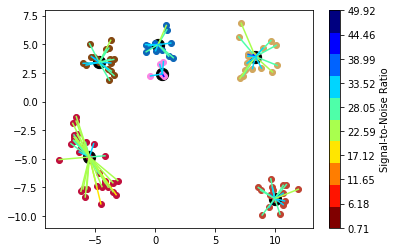

0.724754810333252
{'Cluster Head': 'client84', 'Members': ['client6', 'client7', 'client13', 'client40', 'client41', 'client48', 'client52', 'client60', 'client62', 'client72', 'client80', 'client82', 'client88', 'client92', 'client96', 'client99'], 'SNR': [24.22645922130608, 20.953282125738227, 24.62383533799347, 22.74004612231202, 25.060574751188536, 34.13187146915437, 29.60163613060059, 22.971400248102302, 21.537225140657604, 28.806061365131587, 25.214532593708917, 40.3761989721767, 28.318382014199226, 21.470578094704212, 33.329166321394275, 28.58537688432093], 'CSI': [0.44922696498574544, 0.967511993388575, 0.14215590331302852, 0.09353078562700201, 0.5004009420914397, 0.40807078755591175, 0.7372059296395492, 0.07100493440497657, 0.6072814375912947, 0.8406147996341745, 0.4342179990108648, 0.233934209882937, 0.014403389990054194, 0.43446715581074447, 0.8349143720148923, 0.15374487428401729]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/test/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

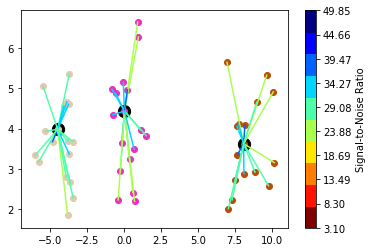

0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.369689


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  response = method(*a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.190751
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.604627

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.532687
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.542871
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.141736

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.309435
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.587462
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.340394

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.372907
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.041447
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.361138

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.133233
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.443216

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.344076
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.158163
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.471827

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.254853
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.621754
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.310738

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288483
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.012802
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.496643

Power Allocated= 4.389554359990696
CSI= 0.415029

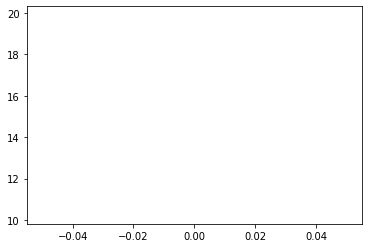

ROUND 0
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.396183


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.678542
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.792767

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.322927
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.718337
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.456765

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.463641
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.933746
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.423729

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.173734
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.444611
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.231967

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.683109
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.261426

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.328407
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.742128
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.017269

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.381318
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.062310
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.730498

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.439714
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.543258
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.421466

Power Allocated= 4.389554359990696
CSI= 0.415029

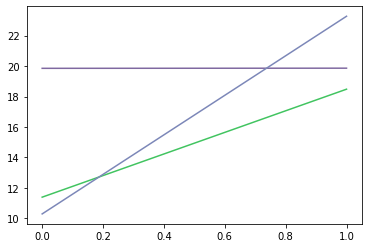

ROUND 1
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.378174


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.158755
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.860350

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.286958
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.861604
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.522494

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.412394
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.881017
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.247124

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.170862
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.565853
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.313711

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.049743
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.215670

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.345709
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.090924
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.692846

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.383247
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.575583
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.034107

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.350733
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.001131
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.419286

Power Allocated= 4.389554359990696
CSI= 0.415029

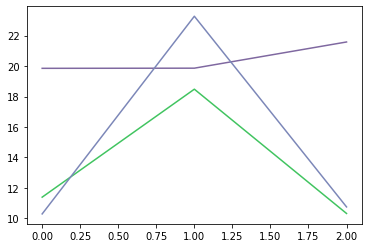

ROUND 2
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.390930


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.672464
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.017928

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294935
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.480496
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.269630

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.484926
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.887393
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.395235

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.117810
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.680788
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.078587

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.649532
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.495106

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.381798
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.837206
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.146260

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.379472
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.850587
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.317215

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.443048
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.973505
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.225646

Power Allocated= 4.389554359990696
CSI= 0.415029

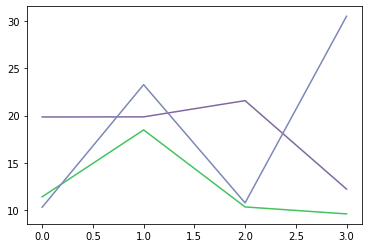

ROUND 3
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.435320


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.906219
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.507646

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.315056
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.610211
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.184962

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.544132
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.654865
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.245109

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.065948
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.137811
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.308771

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.751042
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.846054

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.425618
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.885798
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.724190

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.376219
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.481509
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.729581

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.466110
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.818637
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.043473

Power Allocated= 4.389554359990696
CSI= 0.415029

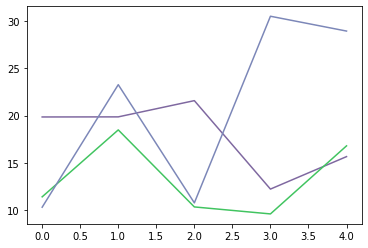

ROUND 4
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.478779


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.652004
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.915162

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.282324
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.371543
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.003245

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.666337
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.401779
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.091165

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.909791
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.420382
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090692

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.142828
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377168

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.500542
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.786922
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.166921

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.549559
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.196876
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417245

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.510955
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.349548
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.021446

Power Allocated= 4.389554359990696
CSI= 0.415029

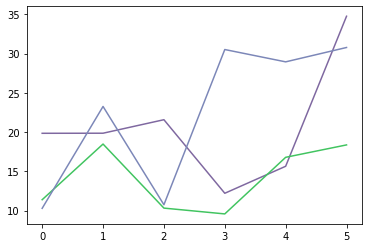

ROUND 5
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.496941


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.351861
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.551057

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.228416
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.150729
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.964507

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.716330
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.286621
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.010707

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.686512
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351609
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040428

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.931047
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.890200

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.505249
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.120239
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.790968

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310823
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.726823
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065186

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.507694
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.232820
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.883554

Power Allocated= 4.389554359990696
CSI= 0.415029

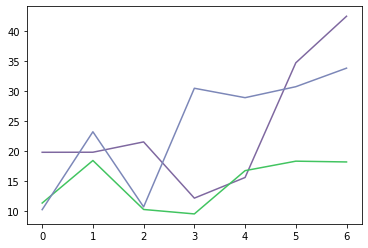

ROUND 6
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.369911


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.648502
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.642370

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.051044
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.786369
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.519524

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.757391
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.972570
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.895002

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.124413
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049877
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020254

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.841725
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.399146

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.315442
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.023513
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.646083

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.429553
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307921
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141541

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.363139
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.752722
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.758225

Power Allocated= 4.389554359990696
CSI= 0.415029

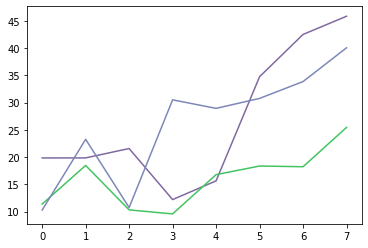

ROUND 7
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.317693


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.677687
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235594

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.936073
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.588642
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.315476

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.857150
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.775129
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.621244

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.782784
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035287
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014656

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.601421
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.343595

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.892059
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.750610
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.341081

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.368276
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.299764
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322947

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.024170
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.830109
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.388848

Power Allocated= 4.389554359990696
CSI= 0.415029

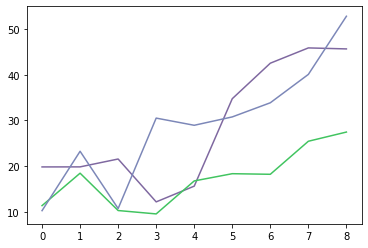

ROUND 8
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.112696


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.458380
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.407485

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.475102
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280839
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214878

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.658719
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.654284
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.640865

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639480
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155820
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000272

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551978
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.388866

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.071163
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.650390
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.386159

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.906848
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069827
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.600207

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.853586
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.446411
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240148

Power Allocated= 4.389554359990696
CSI= 0.415029

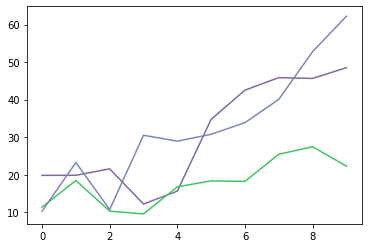

ROUND 9
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.715202


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467541
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.305890

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.557363
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280355
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236166

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.206090
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463791
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167596

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590088
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019816
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002817

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.306761
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201365

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.794398
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362272
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.366789

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.920996
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258199
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.267342

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.600186
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.340410
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203155

Power Allocated= 4.389554359990696
CSI= 0.415029

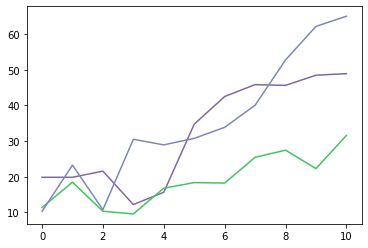

ROUND 10
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.787414


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277091
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069243

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.550733
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188918
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.311731

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.093413
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.492994
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229959

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.656166
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026652
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002677

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.321216
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.101628

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.623065
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.492779
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.186320

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.961429
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245060
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.766549

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.583569
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215773
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.381948

Power Allocated= 4.389554359990696
CSI= 0.415029

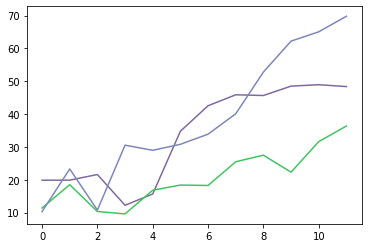

ROUND 11
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.408914


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.380186
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371968

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.249159
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180324
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055823

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.785565
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265473
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169631

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.370595
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038311
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.355118

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246264
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.444315

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.551344
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.377277
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.664807

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.825255
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129087
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158700

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.585060
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.229069
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.444347

Power Allocated= 4.389554359990696
CSI= 0.415029

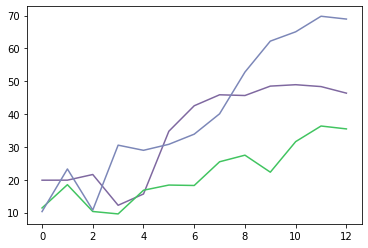

ROUND 12
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.353695


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.318338
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.428882

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.256233
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138201
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218510

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.810036
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153881
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059523

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462409
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123444
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.460504

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145943
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.228817

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.552713
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221334
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108725

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.617801
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037891
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109664

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.172239
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.403879
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144053

Power Allocated= 4.389554359990696
CSI= 0.415029

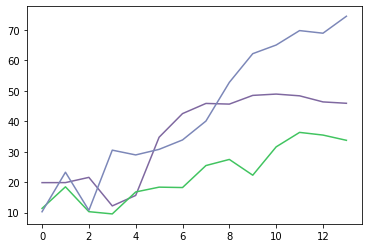

ROUND 13
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.493198


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294408
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120489

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.957831
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122607
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043335

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.739697
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209676
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098520

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470923
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041081
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417925

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307531
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226477

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.238982
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107541
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202891

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.573444
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083427
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.353811

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.410137
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.297529
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.259011

Power Allocated= 4.389554359990696
CSI= 0.415029

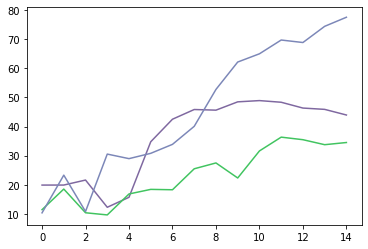

ROUND 14
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.320099


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204376
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091108

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.117527
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152819
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426001

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.724604
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245526
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005053

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392597
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026440
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000174

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081325
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.305219

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.347275
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218580
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.195457

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.516968
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056079
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.178294

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.437758
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254806
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336974

Power Allocated= 4.389554359990696
CSI= 0.415029

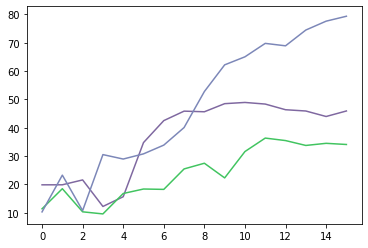

ROUND 15
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.209484


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.261508
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148362

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.753026
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031502
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.245809

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.646738
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218059
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222396

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.322101
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000851
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003777

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272852
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080286

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.350514
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.279374
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159355

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.275720
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030602
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098772

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.246122
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224689
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121073

Power Allocated= 4.389554359990696
CSI= 0.415029

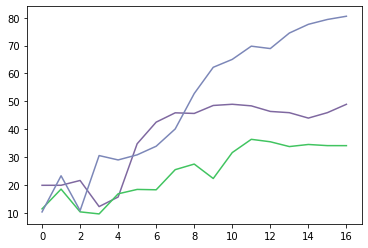

ROUND 16
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.060414


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.436469
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019968

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.937587
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062194
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070886

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.684148
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130642
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156107

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406450
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064669
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108767

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133842
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426539

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.274724
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257898
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124779

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.234559
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091236
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172247

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.262367
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184807
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153061

Power Allocated= 4.389554359990696
CSI= 0.415029

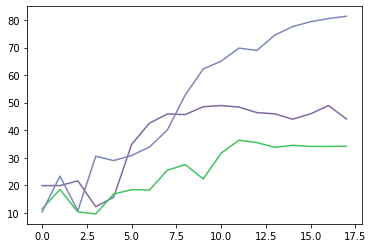

ROUND 17
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.143486


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.412511
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.408095

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712300
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092717
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044015

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.495600
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121983
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048804

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.313232
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005176
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009803

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247172
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097623

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.150788
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193390
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374019

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.504425
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224396
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093491

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.822470
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200477
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.303473

Power Allocated= 4.389554359990696
CSI= 0.415029

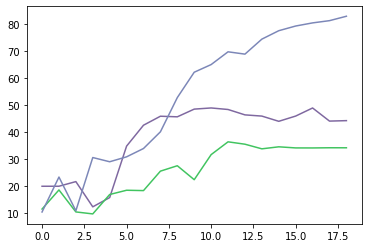

ROUND 18
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.014101


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103016
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092193

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.772711
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247410
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002422

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.314416
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042621
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146800

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341297
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001362
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.130336

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086735
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182230

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.195827
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165869
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059618

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.153780
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003551
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.367646

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.969817
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129286
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240441

Power Allocated= 4.389554359990696
CSI= 0.415029

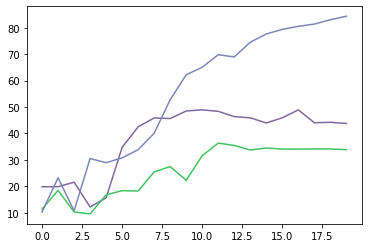

ROUND 19
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.862302


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135950
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283012

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.800588
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133881
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222946

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.619848
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026912
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071372

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.314057
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.338441
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123279

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027886
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185304

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.067827
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039094
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001278

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.073325
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017083
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039586

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.270111
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224873
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335552

Power Allocated= 4.389554359990696
CSI= 0.415029

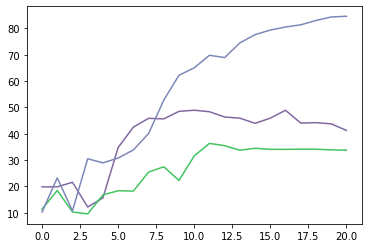

ROUND 20
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.091642


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132485
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069754

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.862015
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069902
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023882

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.229806
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071607
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089452

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324422
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006475
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.670321

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023391
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076398

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.252234
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.338051
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219230

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.367869
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048884
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147607

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.191070
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137739
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336454

Power Allocated= 4.389554359990696
CSI= 0.415029

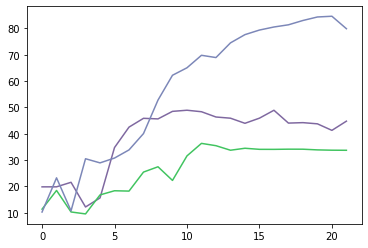

ROUND 21
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.304903


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178957
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093016

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.962622
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003694
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162240

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.355504
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087796
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043963

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321763
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001491
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000225

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056950
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073557

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.208392
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160334
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041246

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.229702
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018393
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003443

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.278777
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268429
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.686648

Power Allocated= 4.389554359990696
CSI= 0.415029

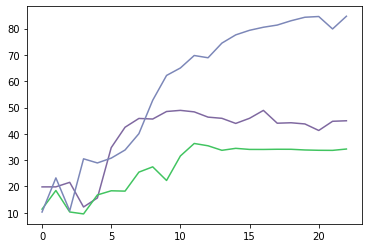

ROUND 22
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.936688


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047832
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044281

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.851430
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018979
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009993

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.260652
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071423
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000743

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327599
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016301
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000964

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108463
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044122

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.179940
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042386
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.339323

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.323963
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046308
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143882

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.194363
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109530
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096690

Power Allocated= 4.389554359990696
CSI= 0.415029

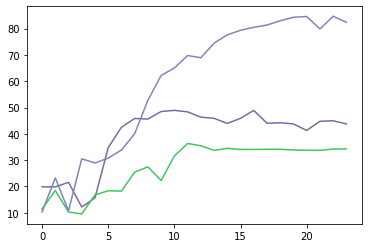

ROUND 23
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.973747


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015013
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139882

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816065
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093435
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058604

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.672139
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139939
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049377

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.309357
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014116
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074512
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135866

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.334826
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052787
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071082

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.294137
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000182
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002531

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.205953
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328597
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169090

Power Allocated= 4.389554359990696
CSI= 0.415029

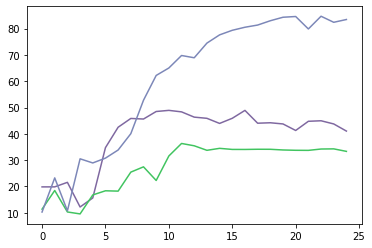

ROUND 24
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116993


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097006
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031940

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.917179
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018644
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020863

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.622820
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066365
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011814

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.382285
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033099
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006749

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055753
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103377

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.978490
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210715
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059618

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.265047
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051332
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016239

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.843853
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106363
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041603

Power Allocated= 4.389554359990696
CSI= 0.415029

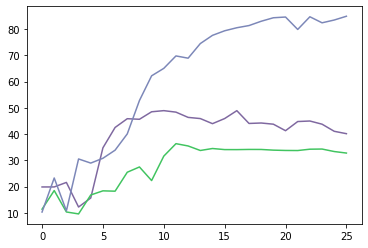

ROUND 25
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.118602


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050071
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112492

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.789232
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011487
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007643

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.679691
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083130
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041271

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.181657
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000006
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056085

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221744
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053831

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.890399
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072514
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215337

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004053
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230502
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028730

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.981127
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.269865
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099460

Power Allocated= 4.389554359990696
CSI= 0.415029

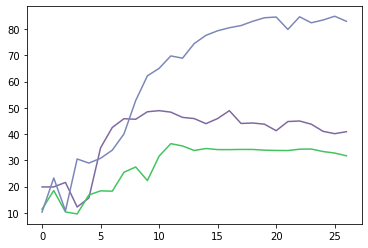

ROUND 26
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.003039


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.299858
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179805

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803446
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084009
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060325

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.255372
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006083
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024243

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.244023
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058713
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001971

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077263
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053559

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.212607
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102377
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118230

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.186844
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195795
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044826

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.127736
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084649
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121965

Power Allocated= 4.389554359990696
CSI= 0.415029

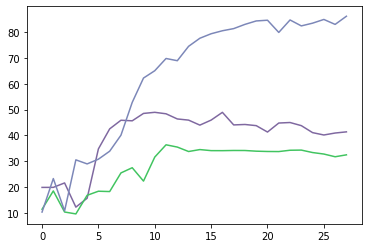

ROUND 27
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.918688


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098116
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075379

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.828787
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013224
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027297

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.513335
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050939
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013582

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367407
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029522
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009663

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059292
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119563

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.973236
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168096
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226775

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.114112
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124299
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007196

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.049466
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052702
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278233

Power Allocated= 4.389554359990696
CSI= 0.415029

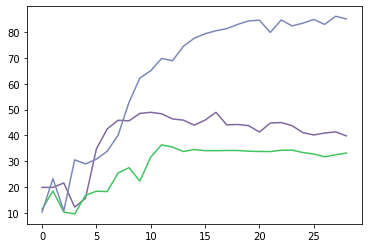

ROUND 28
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.912828


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221685
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016452

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970866
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061039
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008683

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.587667
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264307
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017827

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298223
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000477
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001918

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.433007
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.302435

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.222143
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123447
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014400

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.030912
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114861
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009211

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.139648
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092710
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058218

Power Allocated= 4.389554359990696
CSI= 0.415029

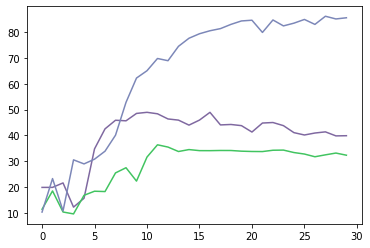

ROUND 29
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877943


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018043
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048582

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.723828
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198614
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020484

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.350452
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031269
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067230

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.264686
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142472
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037145

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022040
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010334

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874876
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023084
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036002

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020219
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011230
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029829

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714518
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184389
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249645

Power Allocated= 4.389554359990696
CSI= 0.415029

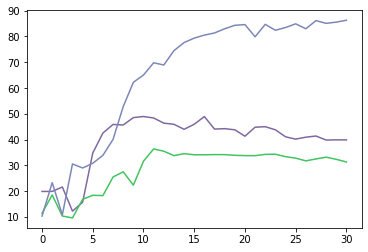

ROUND 30
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.845758


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221230
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.233980

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.767367
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276808
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112447

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.516457
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003693
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.265370
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011630
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000263

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075090
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159587

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.271726
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141896
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172927

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.988810
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.300929
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009448

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.000439
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041967
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147773

Power Allocated= 4.389554359990696
CSI= 0.415029

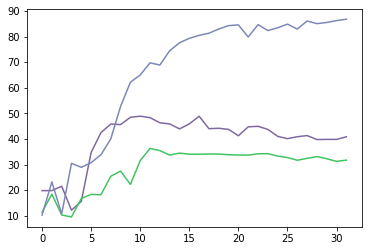

ROUND 31
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.936171


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088605
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030777

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.702867
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116579
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011924

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.298077
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055990
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138060

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273530
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000088
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005900

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047458
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031637

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.124970
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158332
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278944

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.674755
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002595
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449292

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.852987
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127153
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239562

Power Allocated= 4.389554359990696
CSI= 0.415029

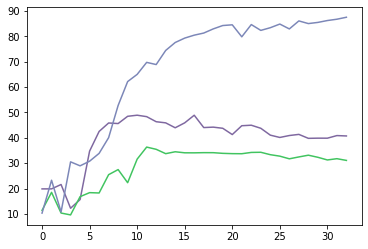

ROUND 32
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.891469


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142367
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070269

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.566885
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072557
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117309

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.615874
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180849
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.448270

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.279618
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004084
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000135

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184629
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170723

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.002776
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121531
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004812

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.168472
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082791
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001320

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.041052
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191393
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031513

Power Allocated= 4.389554359990696
CSI= 0.415029

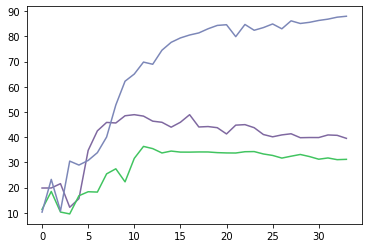

ROUND 33
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803994


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024471
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110543

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877640
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092756
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094438

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.441938
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020514
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129583

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.190840
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058515
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002667

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081272
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202663

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.865630
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162963
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053061

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.185241
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072467
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185172

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797951
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022387
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032442

Power Allocated= 4.389554359990696
CSI= 0.415029

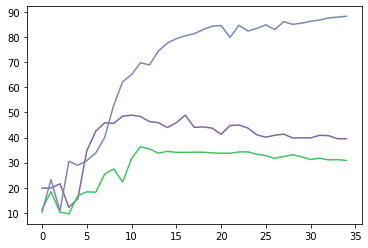

ROUND 34
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.992365


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005032
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010537

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.490889
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000500
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.101118

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.375005
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066006
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115675

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.154112
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000744
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008475

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062459
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181162

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.261402
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196267
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132704

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020783
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000096
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.352767

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816368
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073430
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073825

Power Allocated= 4.389554359990696
CSI= 0.415029

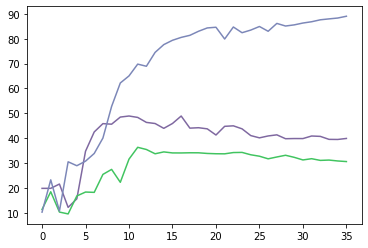

ROUND 35
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.685590


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060924
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128980

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.706187
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090843
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023994

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.193545
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075576
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018724

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.128626
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000114
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000023

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218355
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092121

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.001561
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077653
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.510482

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.155510
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051696
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027637

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803563
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027127
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196110

Power Allocated= 4.389554359990696
CSI= 0.415029

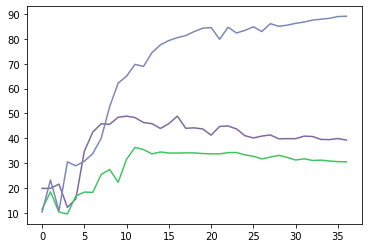

ROUND 36
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.821229


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049414
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119942

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.754157
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056868
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045831

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.103616
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040929
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068865

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.213991
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000070
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002070

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110200
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077108

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.675655
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050676
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062870

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.362595
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028763
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003318

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.852935
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254467
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023421

Power Allocated= 4.389554359990696
CSI= 0.415029

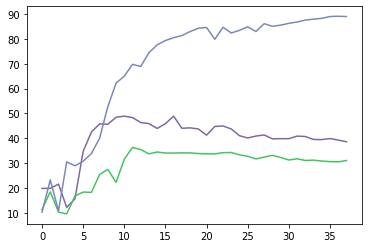

ROUND 37
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.992503


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096014
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054477

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532804
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012664
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051799

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.205071
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040708
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057537

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.187747
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003403
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003669

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108786
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114409

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.884898
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146318
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092958

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.127232
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087522
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003192

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026491
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022635
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125026

Power Allocated= 4.389554359990696
CSI= 0.415029

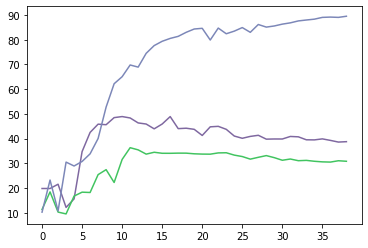

ROUND 38
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.821635


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024082
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231213

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.692967
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004286
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000012

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.175613
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021338
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020293

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.229937
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001005
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000661

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141167
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046707

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.837559
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.368382
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.497078

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.989796
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046089
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032119

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.011040
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153520
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132691

Power Allocated= 4.389554359990696
CSI= 0.415029

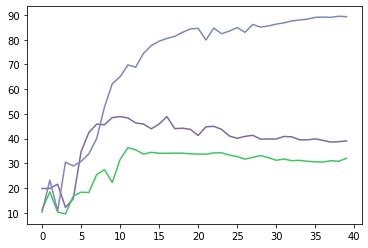

ROUND 39
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.920333


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223336
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151461

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532803
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018259
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076711

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.169891
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013314
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.256385

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.216618
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005429
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.446870
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202194

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.009057
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048058
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175224

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.985873
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054484
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036256

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714576
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089548
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062318

Power Allocated= 4.389554359990696
CSI= 0.415029

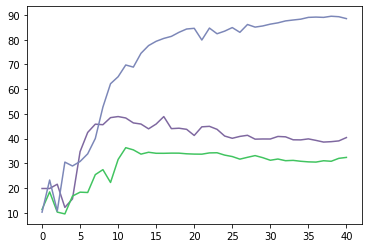

ROUND 40
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.751093


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050529
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028135

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.705869
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005880
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.379124
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027094
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018018

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219359
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012594
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128771

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033734
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151352

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747078
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052677
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003109

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.309424
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076638
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000848

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.030380
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026613
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074270

Power Allocated= 4.389554359990696
CSI= 0.415029

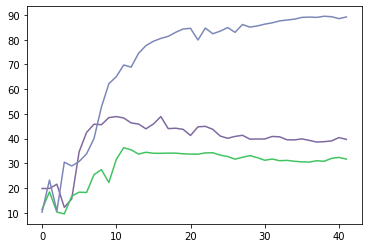

ROUND 41
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.859902


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022637
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016347

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.641729
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000229
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001288

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.005280
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014271
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151222

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.191324
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001048
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003367

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047386
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096861

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874885
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204311
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189871

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.919189
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043473
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.341649

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.875997
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194369
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053512

Power Allocated= 4.389554359990696
CSI= 0.415029

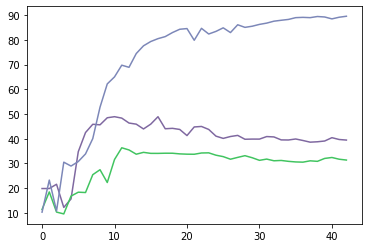

ROUND 42
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.835996


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049697
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008949

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.501080
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117014
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000020

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.391743
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008061
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009976

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.311196
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000009
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000007

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042301
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134618

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848372
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207138
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064865

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.855574
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016936
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173408

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.813817
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074509
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069944

Power Allocated= 4.389554359990696
CSI= 0.415029

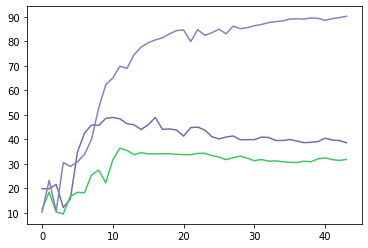

ROUND 43
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.773746


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115271
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090041

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.671803
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044192
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004525

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.969109
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063473
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039804

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.280072
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000753
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058683

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012126
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.392528

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.061026
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075573
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072219

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932303
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132082
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046718

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.916281
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005098
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115761

Power Allocated= 4.389554359990696
CSI= 0.415029

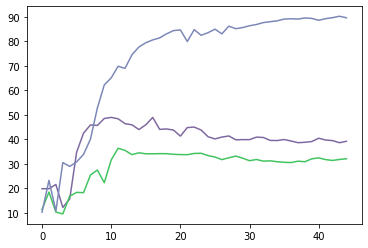

ROUND 44
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.731729


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003404
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155178

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537104
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014581
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095707

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.243910
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050334
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075843

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.124167
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105645
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.739175

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057651
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484825

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.883203
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077084
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006410

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.097939
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005281
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002310

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.821568
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077390
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088519

Power Allocated= 4.389554359990696
CSI= 0.415029

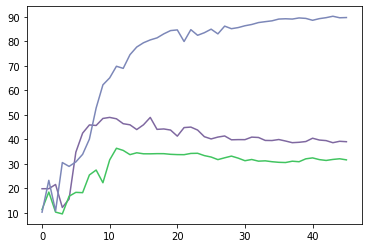

ROUND 45
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944982


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051561
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003832

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610715
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023732
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027172

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.475800
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043908
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045339

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.184958
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054856
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000297

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047427
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010107

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.782398
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086823
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198527

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.937674
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034025
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077981

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.904563
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084570
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041786

Power Allocated= 4.389554359990696
CSI= 0.415029

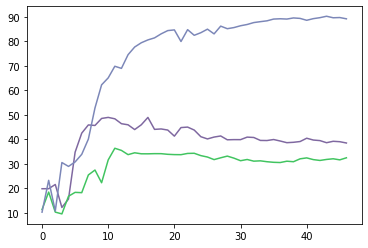

ROUND 46
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.838533


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230576
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153175

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.433908
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013232
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000004

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.329251
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048953
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004691

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.223502
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000034
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001775

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033127
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174318

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.939952
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108708
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086979

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.105362
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028657
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025560

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.971295
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152992
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066538

Power Allocated= 4.389554359990696
CSI= 0.415029

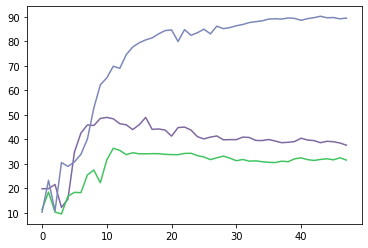

ROUND 47
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897312


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170790
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148034

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.668587
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004944
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000654

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.058522
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049529
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109429

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208860
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001788
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003671

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047181
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098951

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.873310
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064986
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044452

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.807427
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015749
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001047

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.063021
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079983
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426849

Power Allocated= 4.389554359990696
CSI= 0.415029

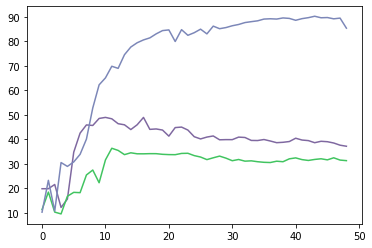

ROUND 48
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026424


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042963
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027203

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720619
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019685
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.836806
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131503
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033188

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.154376
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006205
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.518159

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113717
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.548856

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.154890
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019589
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062018

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.003055
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132597
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.664319

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.855018
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024343
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081408

Power Allocated= 4.389554359990696
CSI= 0.415029

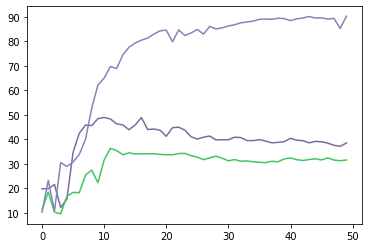

ROUND 49
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.972842


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021850
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.253387

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457906
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012787
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000257

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.409168
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011477
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013041

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261751
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002870
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006163

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151031
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015068

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.836443
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151067
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006041

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.952538
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022818
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071761

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.956202
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094971
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089822

Power Allocated= 4.389554359990696
CSI= 0.415029

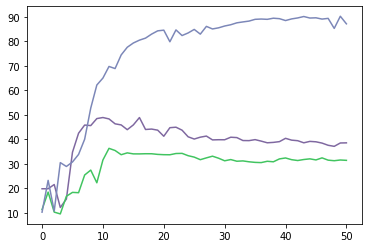

ROUND 50
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.109542


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067687
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185293

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634263
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002121
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001070

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.162289
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015845
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015591

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350394
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000256
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000041

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146532
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134059

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.125686
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184064
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001375

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877485
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072227
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154020

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.045069
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054562
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137380

Power Allocated= 4.389554359990696
CSI= 0.415029

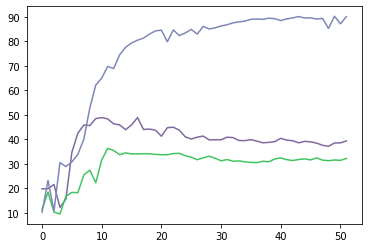

ROUND 51
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.775114


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006781
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068343

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.599289
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023273
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002481

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.340442
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053513
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138048

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172871
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003850
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.192170

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018545
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093921

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.984091
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020596
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001323

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.320576
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063514
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027542

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.114709
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.780946
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099297

Power Allocated= 4.389554359990696
CSI= 0.415029

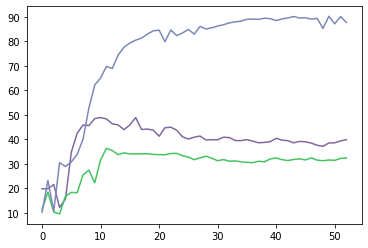

ROUND 52
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.767114


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080213
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001700

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.579673
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000197
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181759

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.414669
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014378
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170849

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.188988
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090563
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000033

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035952
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.370137

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.922837
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010402
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030834

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.131277
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015053
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086667

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.061500
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096112
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.363188

Power Allocated= 4.389554359990696
CSI= 0.415029

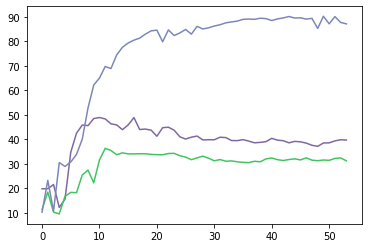

ROUND 53
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720504


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016852
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064739

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.635661
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023077
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125913

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.304531
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016203
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051637

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.217967
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028956
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.130828

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039708
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.312208

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.935118
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323622
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025212

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.044625
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113733
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031920

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.161485
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093548
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123340

Power Allocated= 4.389554359990696
CSI= 0.415029

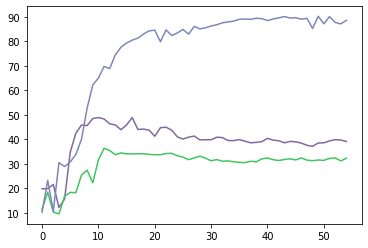

ROUND 54
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.627012


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060340
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016240

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.561817
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161502
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054088

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.382099
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.349646
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174419

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.287556
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000545
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000064

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080954
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.668954

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.895463
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007277
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269412

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.987905
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058639
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012122

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.856301
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052109
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377123

Power Allocated= 4.389554359990696
CSI= 0.415029

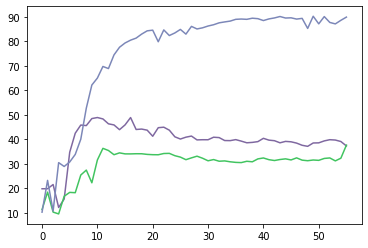

ROUND 55
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640610


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026873
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017324

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703370
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015918
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011463

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.116199
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063539
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289257

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.203350
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000133
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000509

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022435
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045887

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690731
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031780
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091473

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.024506
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035177
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061053

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.930285
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025735
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112507

Power Allocated= 4.389554359990696
CSI= 0.415029

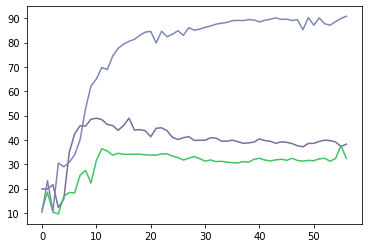

ROUND 56
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760762


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019076
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002488

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.665561
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000890
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003847

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.161805
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089450
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097929

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.159624
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031063
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000002

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026554
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.797918

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.953723
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068394
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040558

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.896850
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001676
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026638

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.809372
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029782
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091767

Power Allocated= 4.389554359990696
CSI= 0.415029

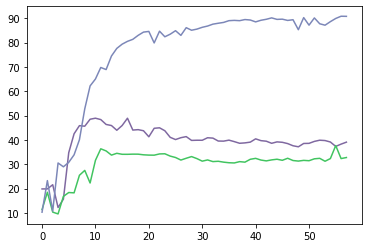

ROUND 57
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593756


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037351
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037321

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.479777
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005293
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000474

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.241117
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075417
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100866

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.218097
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001704
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182247
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077508

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940964
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005373
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043975

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.062999
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003219
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001926

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.967611
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033175
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057756

Power Allocated= 4.389554359990696
CSI= 0.415029

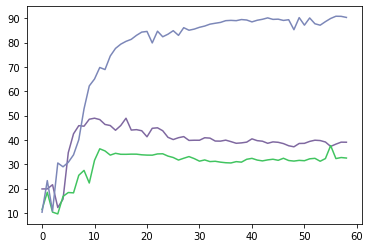

ROUND 58
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615370


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052579
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144505

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.529880
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043796
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000441

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.229966
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046285
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015173

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.136524
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045033
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001006

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158616
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240589

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.774681
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111784
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010265

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.822674
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052634
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002185

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.964116
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027507
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008969

Power Allocated= 4.389554359990696
CSI= 0.415029

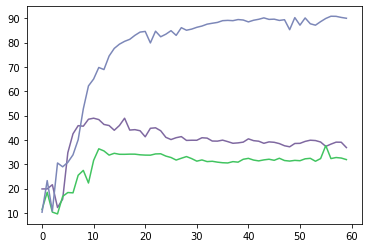

ROUND 59
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.739452


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069686
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016370

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564130
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002287
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106024

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.294224
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057808
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075878

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.203204
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000002
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066061
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205821

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.975628
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025504
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252273

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.975636
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032327
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105275

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.657883
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065178
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018583

Power Allocated= 4.389554359990696
CSI= 0.415029

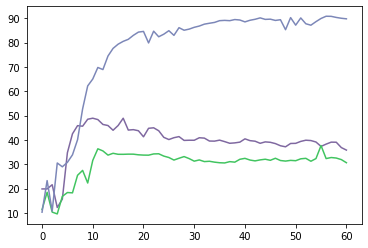

ROUND 60
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.780016


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002070
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.228692

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.470699
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062974
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073424

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.964150
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019725
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015926

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.401702
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000140
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000086

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107372
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201293

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.913397
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060655
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111267

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.028322
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000360
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000292

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716187
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012429
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078304

Power Allocated= 4.389554359990696
CSI= 0.415029

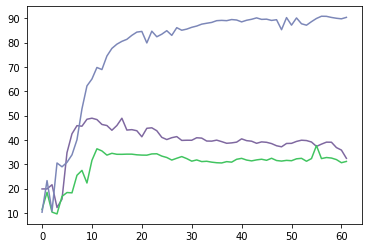

ROUND 61
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848737


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027711
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000649

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447178
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002623
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.131605

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.174182
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086765
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000216

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.205762
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000022
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000070

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019929
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247663

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.033270
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019745
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013173

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.916045
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055136
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220108

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734534
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019582
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215606

Power Allocated= 4.389554359990696
CSI= 0.415029

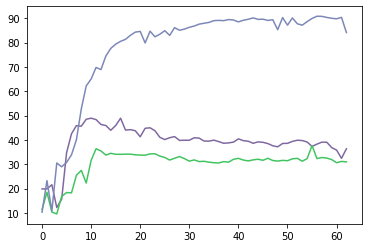

ROUND 62
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.943153


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037943
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.164467

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.853801
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034301
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013402

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.814843
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079052
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014834

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.317103
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000062
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004824

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069249
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048329

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.106552
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030448
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017390

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.199375
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009613
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008962

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.961209
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050160
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022329

Power Allocated= 4.389554359990696
CSI= 0.415029

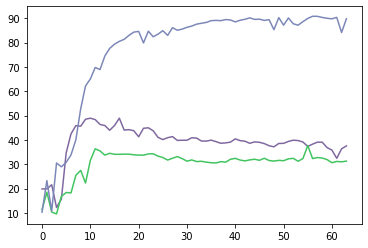

ROUND 63
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.735647


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049877
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.233378

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586384
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001383
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001363

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.039417
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192896
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313393

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240902
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039354
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203396

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048866
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014443

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008237
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003636
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016093

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.823878
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003340
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102554

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.872077
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011632
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056456

Power Allocated= 4.389554359990696
CSI= 0.415029

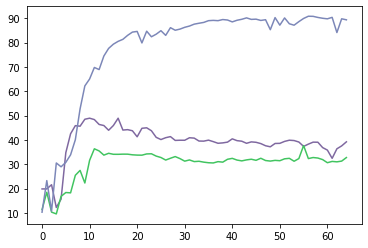

ROUND 64
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.773894


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069959
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015167

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.903279
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000777
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142649

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.179114
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036161
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002123

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.323027
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003273
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155991
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199443

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.996203
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067103
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024450

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.121087
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019771
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022139

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.062619
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052042
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096341

Power Allocated= 4.389554359990696
CSI= 0.415029

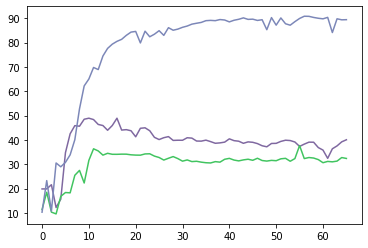

ROUND 65
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.617186


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033097
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055121

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667706
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073389
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016233

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.007667
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061264
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090957

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275282
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003275
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014903

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.320997
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024225

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.655444
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024844
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080420

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.042870
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002518
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005227

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.693519
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056765
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062842

Power Allocated= 4.389554359990696
CSI= 0.415029

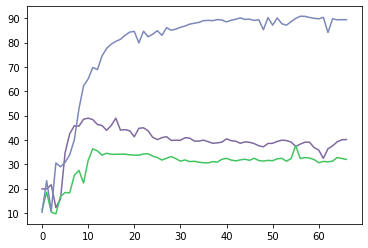

ROUND 66
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.778515


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016005
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011899

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.576293
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067990
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140188

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.054446
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018759
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013620

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.330538
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000042
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095426
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158793

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.773933
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073013
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021127

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.163367
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016385
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070752

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.025579
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078393
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193286

Power Allocated= 4.389554359990696
CSI= 0.415029

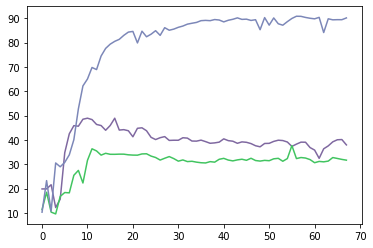

ROUND 67
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.688482


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029318
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017555

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.687576
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018987
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321255

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.075282
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007850
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005123

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.175953
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001099
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133016
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160324

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.891321
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007107
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008520

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.081352
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017364
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060531

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.893307
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029216
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022137

Power Allocated= 4.389554359990696
CSI= 0.415029

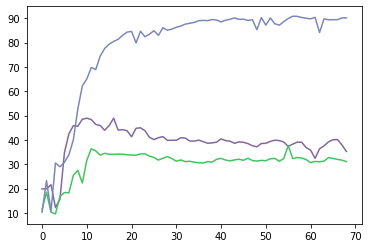

ROUND 68
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.669141


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007312
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189433

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563919
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033780
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005179

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885120
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069928
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012289

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206239
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000025
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100875

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201442
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.196101

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.847520
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013167
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053383

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.100236
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011957
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088334

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.732640
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010668
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113747

Power Allocated= 4.389554359990696
CSI= 0.415029

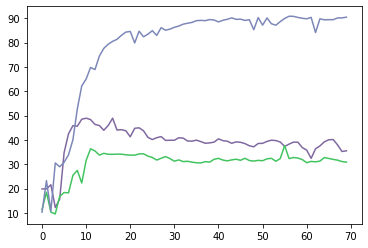

ROUND 69
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.638745


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011398
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009708

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426323
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002652
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132694

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.464748
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068345
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020882

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.131064
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033098
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117562

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015904
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.692849

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.775809
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000138
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004251

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.090896
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012133
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102616

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.850888
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058155
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027841

Power Allocated= 4.389554359990696
CSI= 0.415029

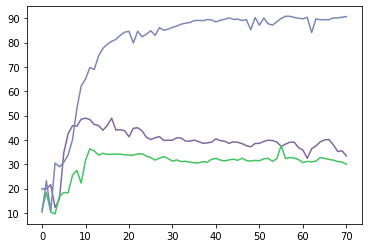

ROUND 70
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.943552


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277223
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038370

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.776999
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010090
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.153931
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049258
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057376

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.193240
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000070

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039857
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020769

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.813308
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021124
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074569

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.866850
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001293
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015592

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.785411
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065812
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033140

Power Allocated= 4.389554359990696
CSI= 0.415029

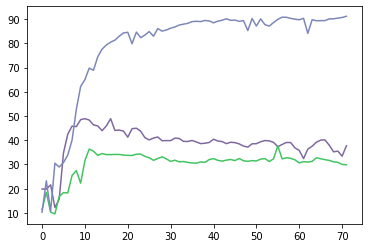

ROUND 71
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532302


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.388707
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055010

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639847
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009318
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001044

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.986227
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010717
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041439

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.317227
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014158
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000965

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132059
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011922

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.995657
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026987
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.542485

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.299474
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014224
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020963

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.779475
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014240
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026131

Power Allocated= 4.389554359990696
CSI= 0.415029

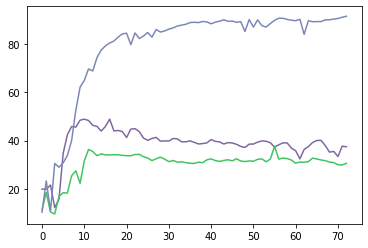

ROUND 72
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.679877


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007408
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014746

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.616004
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008386
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003621

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.038198
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064365
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323926

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.209082
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000155
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061129
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063911

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803152
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112094
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191571

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.925801
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000376
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059520

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.808886
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023069
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043410

Power Allocated= 4.389554359990696
CSI= 0.415029

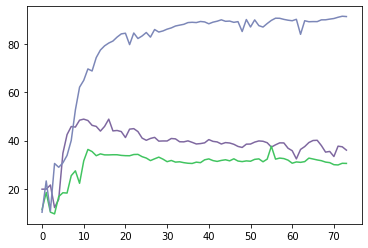

ROUND 73
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.907842


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012625
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.522525

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.628342
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021830
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038934

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.075831
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054189
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.348848

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.282440
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000035
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000569

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101228
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102183

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.966827
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065790
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053938

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932166
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190711
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001807

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763216
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017111
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115778

Power Allocated= 4.389554359990696
CSI= 0.415029

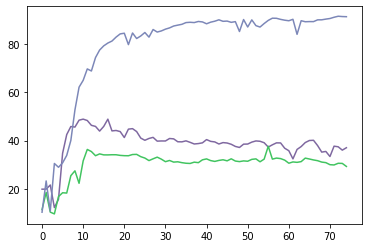

ROUND 74
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.617729


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181771
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162961

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.425776
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000551
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000228

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.076756
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.195582
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089753

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.153582
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000008
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093755
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019424

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.796715
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066722
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015215

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.850545
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004504
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008308

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.857483
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121404
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033031

Power Allocated= 4.389554359990696
CSI= 0.415029

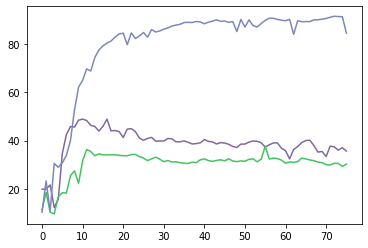

ROUND 75
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.231095


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115174
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066816

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567071
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000210
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000386

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.812512
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026960
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023993

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206179
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000096
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056917
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061582

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.012147
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011306
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008928

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.012000
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123460
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116714

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.842618
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029475
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053778

Power Allocated= 4.389554359990696
CSI= 0.415029

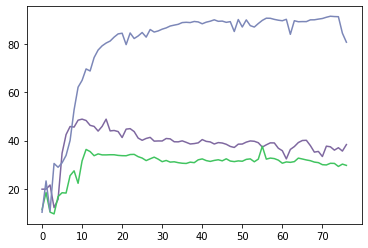

ROUND 76
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.216749


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033852
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035169

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.687508
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000570
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002624

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.855173
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030207
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011636

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325040
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023343
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048383

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032222
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051433

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.051675
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030043
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093123

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.893158
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015778
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114029

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.279211
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061685
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.188785

Power Allocated= 4.389554359990696
CSI= 0.415029

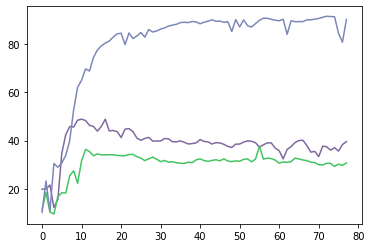

ROUND 77
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.928781


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031320
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058247

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379483
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053408
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.786284
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004929
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031141

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.293783
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000244
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081199
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184924

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.857144
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009367
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322693

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.180138
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043380
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162366

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.858957
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004911
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149670

Power Allocated= 4.389554359990696
CSI= 0.415029

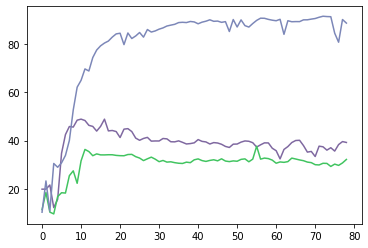

ROUND 78
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.780727


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113286
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039002

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587765
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011295
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.178334
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000979
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059130

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.285865
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045053
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198459

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803947
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023370
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028388

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.263957
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015198
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.704079

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.145696
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173751
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.165767

Power Allocated= 4.389554359990696
CSI= 0.415029

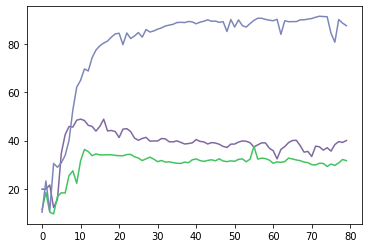

ROUND 79
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.559033


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039948
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059925

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747934
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046644
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.489219

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.568300
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011344
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052983

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219175
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000350
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001170

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013724
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197920

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.852508
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081010
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103138

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.211874
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017293
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144004

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008161
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036143
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074420

Power Allocated= 4.389554359990696
CSI= 0.415029

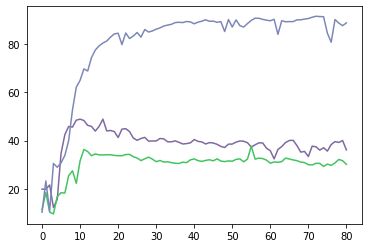

ROUND 80
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.710849


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031493
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050756

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.722599
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.371455
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.433514

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.083863
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052054
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051315

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.232164
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004338
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034647
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237574

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.871056
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134917
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064984

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.904715
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076173
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021640

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.984230
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032382
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.464324

Power Allocated= 4.389554359990696
CSI= 0.415029

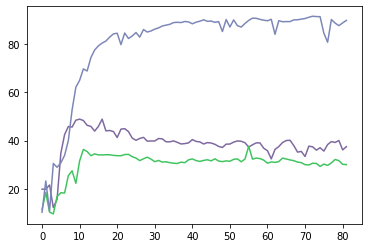

ROUND 81
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621138


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057917
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067577

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.599303
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227050
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.543275

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.070853
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013259
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028854

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.244771
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000027
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003771
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029948

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.646438
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033078
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048030

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.392080
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032520
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050453

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.830836
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007206
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141213

Power Allocated= 4.389554359990696
CSI= 0.415029

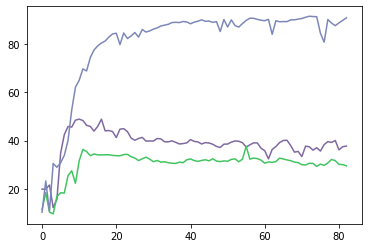

ROUND 82
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795403


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007791
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134732

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.622727
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.996879
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029629

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.167930
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055023
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057455

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316782
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185663
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002745
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030291

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932414
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027342
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084679

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947394
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203724
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018692

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.987304
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028213
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056537

Power Allocated= 4.389554359990696
CSI= 0.415029

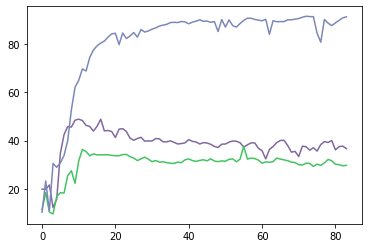

ROUND 83
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747334


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053186
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079892

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.654187
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032910
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078553

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.278991
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037490
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000248

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.152386
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000005
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061286
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176096

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.831759
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033686
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000060

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.975507
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013759
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025763

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.766645
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188722
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004231

Power Allocated= 4.389554359990696
CSI= 0.415029

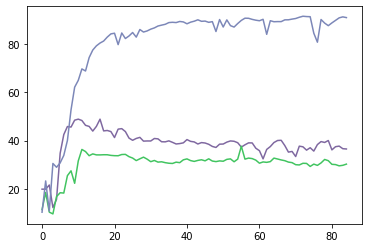

ROUND 84
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714051


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070348
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014019

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.493004
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079200
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002799

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.124990
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059652
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001797

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.247383
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005580
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046763
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091106

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.890492
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033838
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018252

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.757853
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024765
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055593

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.084035
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239044
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028875

Power Allocated= 4.389554359990696
CSI= 0.415029

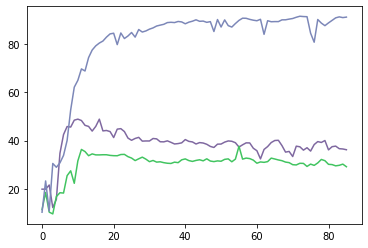

ROUND 85
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940255


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023342
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063401

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634448
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467099
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034232

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.082044
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029925
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042323

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.157805
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000005
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088677

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046478
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310017

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.860983
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047341
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000028

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.121680
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101893
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034238

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.642710
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090538
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001270

Power Allocated= 4.389554359990696
CSI= 0.415029

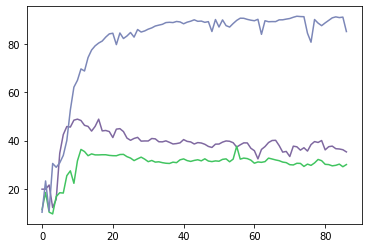

ROUND 86
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.998631


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055569
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102684

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629424
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055071
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008178

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794313
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003645
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074396

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.271647
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000002
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064078
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159298

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.022454
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009561
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.021570

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.946112
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059178
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073355

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.099753
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137320
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.575858

Power Allocated= 4.389554359990696
CSI= 0.415029

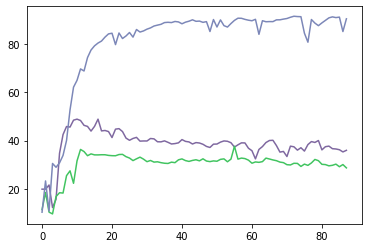

ROUND 87
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512853


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034240
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005772

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446456
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008469
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000080

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740460
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021073
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016522

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.224874
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050694
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.491880

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848119
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020327
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.503839

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053676
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034516
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055863

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.773344
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027256
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154058

Power Allocated= 4.389554359990696
CSI= 0.415029

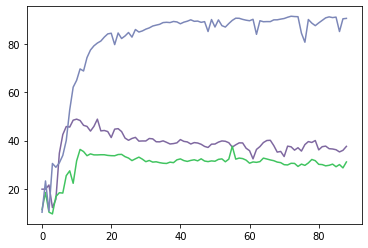

ROUND 88
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017491


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115149
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162620

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400972
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072217
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000789

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.167151
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026812
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000107

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.121727
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000240
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028956
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163889

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.851388
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014195
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005615

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.967729
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014720
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065094

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.701182
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067270
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153944

Power Allocated= 4.389554359990696
CSI= 0.415029

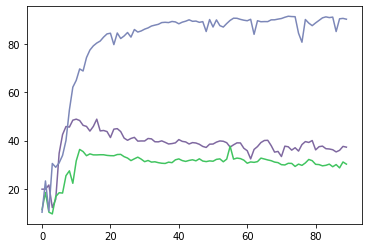

ROUND 89
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.762212


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030509
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004480

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357336
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005531
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000934

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.036680
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020787
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030863

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.254678
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003366
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.664871

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040203
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036860

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.818957
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.296634
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014033

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.024815
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025064
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004185

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.284830
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039173
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055747

Power Allocated= 4.389554359990696
CSI= 0.415029

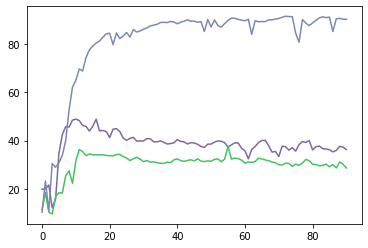

ROUND 90
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.699061


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003173
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148540

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410326
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000614
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126259

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.343648
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035181
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.142662

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.247734
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064470
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000046

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019843
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002416

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.918359
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014414
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038566

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947133
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017628
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022950

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.113140
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037172
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055359

Power Allocated= 4.389554359990696
CSI= 0.415029

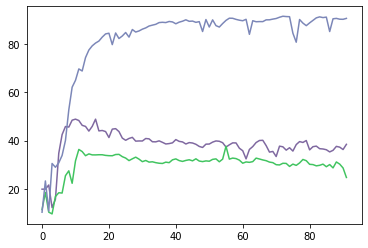

ROUND 91
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667537


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027222
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000555

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417283
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009639
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250734

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.346049
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018843
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032336

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206947
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003203
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000161

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006555
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051069

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.770138
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014985
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190464

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.972188
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043215
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000002

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.787864
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008969
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.271638

Power Allocated= 4.389554359990696
CSI= 0.415029

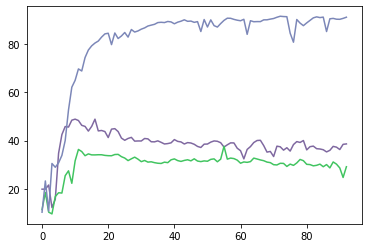

ROUND 92
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716135


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031012
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000177

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481299
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066150
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008416

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.031382
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033628
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007055

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.106526
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033365
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026768

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044750
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246090

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.717362
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013914
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.152918

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.969586
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019825
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064606

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.671827
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010485
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036895

Power Allocated= 4.389554359990696
CSI= 0.415029

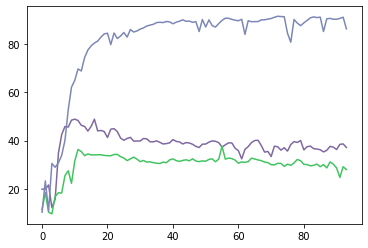

ROUND 93
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.016286


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059431
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498303
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001127
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077125

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.911147
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166024
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013041

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.270361
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001163
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001233

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022693
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.188992

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.783208
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074304
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000529

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.817550
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024738
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009516

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.018667
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037349
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017361

Power Allocated= 4.389554359990696
CSI= 0.415029

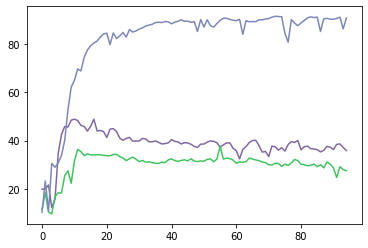

ROUND 94
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.533122


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226860
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000440

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740671
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016755
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066347

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590061
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001539
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000821

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.226943
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000713
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005490

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067256
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004158

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.882919
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014062
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007870

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.866635
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010767
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000191

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970452
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037944
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.167071

Power Allocated= 4.389554359990696
CSI= 0.415029

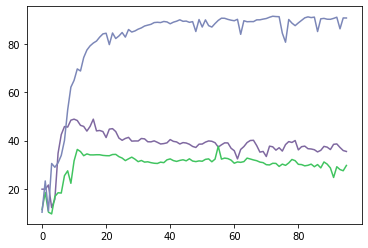

ROUND 95
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.707589


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018555
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008606

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542806
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022597
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053343
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058154
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000059

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.151514
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001016
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000027

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038693
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051114

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629048
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042544
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000466

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.729304
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044200
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118420

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.859764
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074140
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115260

Power Allocated= 4.389554359990696
CSI= 0.415029

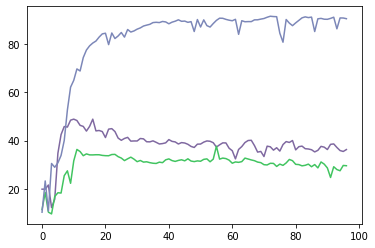

ROUND 96
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.819343


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019524
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060071

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526672
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007279
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041702

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.109049
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009758
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151848

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377849
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000030
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.223175

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134690
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047444

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667974
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011436
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230261

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.117256
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007168
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103338

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.770088
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025350
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008778

Power Allocated= 4.389554359990696
CSI= 0.415029

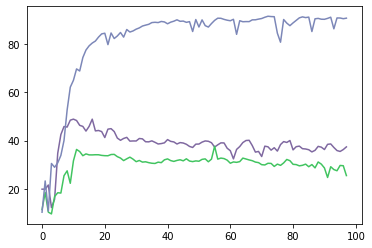

ROUND 97
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.784230


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137342
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022825

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.566758
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002110
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002524

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.966152
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027936
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000002

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.161918
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000315
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059602

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094358
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072585

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.680808
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062831
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018586

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.173770
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024529
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013986

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.854842
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077073
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.391210

Power Allocated= 4.389554359990696
CSI= 0.415029

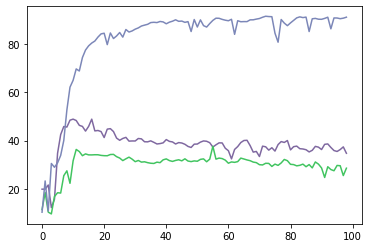

ROUND 98
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.546797


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025452
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043581

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.554573
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024268
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023539

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.133919
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016509
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004950

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.153017
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001274
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000539

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121268
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066688

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848172
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004845
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085470

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.117608
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000997
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008761

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.820154
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053653
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065742

Power Allocated= 4.389554359990696
CSI= 0.415029

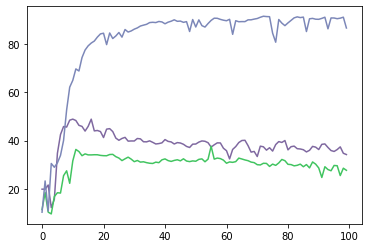

ROUND 99
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763344


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162231
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161533

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449957
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000506
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.802795
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007746
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004907

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.152956
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003636
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000202

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044103
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207325

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.009387
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025202
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058570

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.843608
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011267
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063609

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.173799
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007501
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019075

Power Allocated= 4.389554359990696
CSI= 0.415029

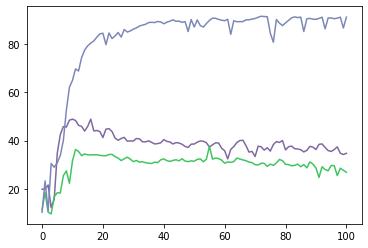

ROUND 100
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.914615


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039082
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087426

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.423484
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005227
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326289

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.921425
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022150
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107629

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206137
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000097
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.118407

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026748
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004649

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797537
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025225
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012942

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634640
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005921
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069661

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.010055
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043398
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.402400

Power Allocated= 4.389554359990696
CSI= 0.415029

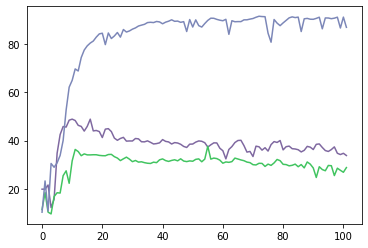

ROUND 101
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.119740


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025876
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330845

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537035
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028540
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.351926

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.916180
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110230
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033819

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.491789
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000095

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058917
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134156

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.891635
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023037
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004067

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.956997
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235165
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632668
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073586
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211899

Power Allocated= 4.389554359990696
CSI= 0.415029

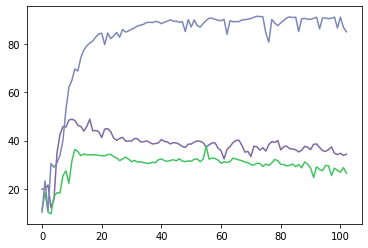

ROUND 102
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.934706


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033645
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042325

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.409927
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017150
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043742

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.950261
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004326
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206270

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.255162
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075026
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.765913

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123052
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.746459

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.165116
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023765
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008954

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797305
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179346
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100527

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.997895
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058148
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057474

Power Allocated= 4.389554359990696
CSI= 0.415029

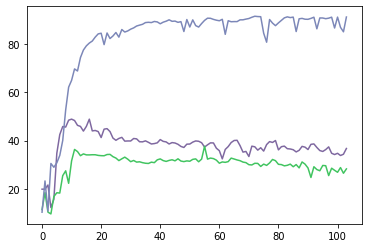

ROUND 103
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.523835


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024639
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001381

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569975
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000590
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036778

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.035937
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011408
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.597951

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.198006
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302641
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480834

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012560
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088567

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.854605
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011876
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002727

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721521
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043465
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147693

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.685112
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081933
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094709

Power Allocated= 4.389554359990696
CSI= 0.415029

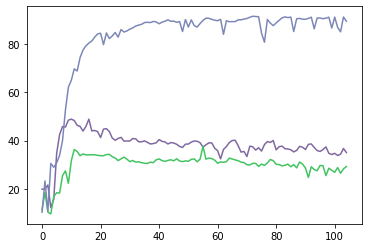

ROUND 104
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740945


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.396264
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147612

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457361
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007118
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008647

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.365108
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118967
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098209

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356867
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260650
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285323

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120205
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246549

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.792302
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031046
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.034556

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.264972
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082066
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000946

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.837997
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047422
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000417

Power Allocated= 4.389554359990696
CSI= 0.415029

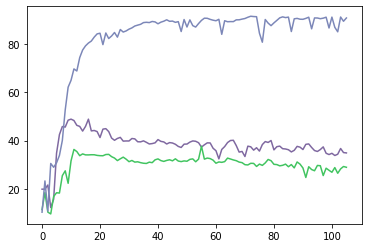

ROUND 105
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.688573


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123671
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029557

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649485
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000479
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000712

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.821044
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.583064
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134454

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.234878
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000260
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026532

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117274
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041335

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.751291
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005519
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022599

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816190
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076508
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068856

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.886937
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019007
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086031

Power Allocated= 4.389554359990696
CSI= 0.415029

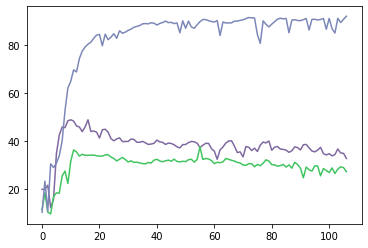

ROUND 106
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714213


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015775
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134783

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371953
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000140
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006180

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.125466
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051092
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102444

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.184040
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089347
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255963

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002040
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078460

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.782775
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024054
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000670

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.903173
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024077
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070708

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.828623
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104329
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025355

Power Allocated= 4.389554359990696
CSI= 0.415029

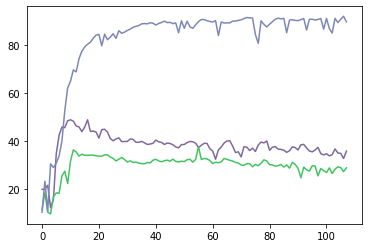

ROUND 107
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.837508


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014599
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028561

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442587
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042030
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009409

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.175294
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075116
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069236

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.308049
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001516
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061767

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070671
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.946901

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.776493
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000920
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008365

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.027548
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049071
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005390

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932379
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009932
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.350084

Power Allocated= 4.389554359990696
CSI= 0.415029

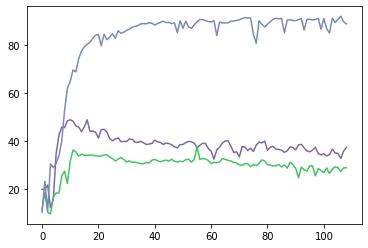

ROUND 108
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897484


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026329
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000148

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.809061
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005632
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005505

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.576787
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058981
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013656

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252050
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011467
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017779

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046555
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.195063

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.908378
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030180
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095782

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.934981
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084768
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099854

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.027903
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121191
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040694

Power Allocated= 4.389554359990696
CSI= 0.415029

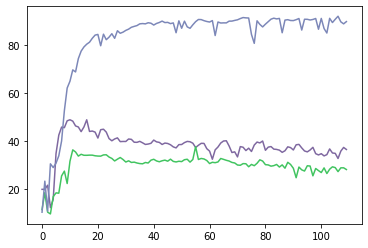

ROUND 109
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.837211


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004545
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.761262

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.397708
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026691
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015187

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.862461
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078059
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204462

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.182018
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018958
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000162

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042613
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158410

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.027888
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086011
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181939

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.050103
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009491
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154156

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.681757
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009304
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095542

Power Allocated= 4.389554359990696
CSI= 0.415029

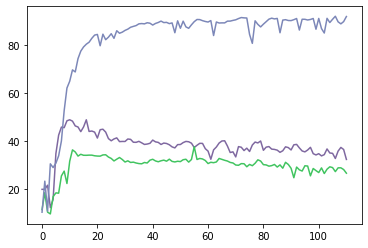

ROUND 110
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.706443


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009762
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162146

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.598349
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010326
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018295

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.160234
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045762
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029912

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.177116
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000072
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000487

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168739
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.293627

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.841363
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032435
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175417

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.790365
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022910
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067092

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.861554
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066413
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090533

Power Allocated= 4.389554359990696
CSI= 0.415029

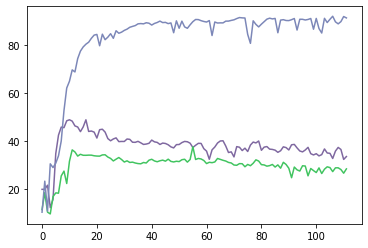

ROUND 111
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605766


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099340
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199675

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535915
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014353
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.182416
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085101
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053322

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.322328
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029998
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.513853

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038803
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.613017

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.550735
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046783
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000004

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.910905
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021529
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001760

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.717283
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109846
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.399084

Power Allocated= 4.389554359990696
CSI= 0.415029

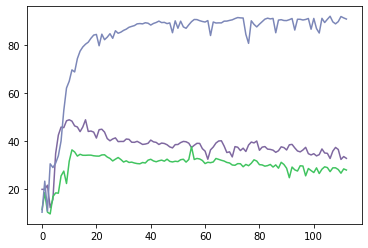

ROUND 112
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.677912


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013975
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056869

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.500777
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016452
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006495

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.078334
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037380
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004400

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422838
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000128
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045796
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173370

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794635
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050549
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106382

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.974611
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010647
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064912

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.968495
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039747
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011089

Power Allocated= 4.389554359990696
CSI= 0.415029

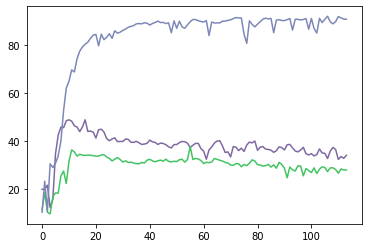

ROUND 113
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.737877


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117178
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000110

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.625850
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074241
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.676863

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.281213
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026714
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184732

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231584
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000008
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060500
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041288

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.500917
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013760
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.420717

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.943129
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027412
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022133

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.722203
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085615
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099444

Power Allocated= 4.389554359990696
CSI= 0.415029

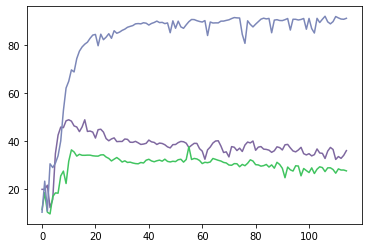

ROUND 114
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874321


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053116
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014654

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563044
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053981
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013360

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.968594
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079911
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018874

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360481
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000079
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011979
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070063

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.769094
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042565
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052638

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.957092
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100015
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060500

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.743877
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144224
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121635

Power Allocated= 4.389554359990696
CSI= 0.415029

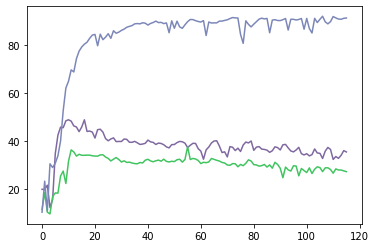

ROUND 115
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.606599


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039010
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024849

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609787
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034114
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185792

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.024181
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038860
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357438

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.250228
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000262
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000135

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245037
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012478

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.982568
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018199
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044585

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.920774
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009320
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000327

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.759819
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061977
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043008

Power Allocated= 4.389554359990696
CSI= 0.415029

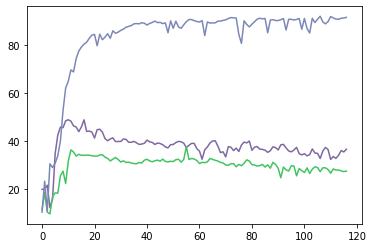

ROUND 116
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.684498


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062141
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009048

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.573528
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046034
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.953727
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074578
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050131

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.225388
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073076
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010357

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.759995
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035519
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044545

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.477517
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087015
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003413

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609018
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022343
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126406

Power Allocated= 4.389554359990696
CSI= 0.415029

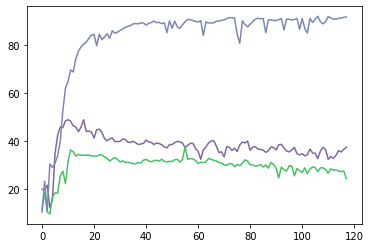

ROUND 117
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.689600


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112959
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000007

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.666671
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000139
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006919

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.026671
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.737387
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.807806

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252509
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000017
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001783

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078736
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033792

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.698093
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003134
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051996

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632086
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026269
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011473

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.672035
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049867
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008440

Power Allocated= 4.389554359990696
CSI= 0.415029

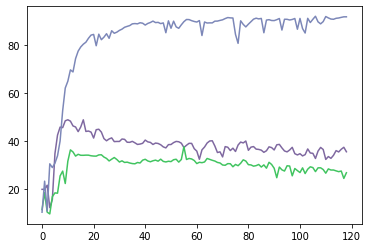

ROUND 118
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763311


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022114
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276927

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.650875
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000446
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.406681
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000350
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011637

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.306875
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032893
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076561
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085399

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.022478
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184571
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011591

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.883100
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028903
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.957577
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000730
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041988

Power Allocated= 4.389554359990696
CSI= 0.415029

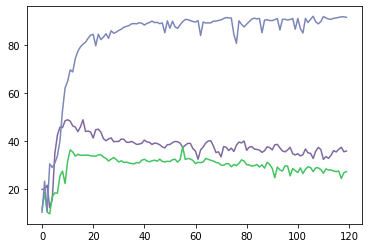

ROUND 119
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.941014


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091761
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040967

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460146
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127322
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185536

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.338233
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018598
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007633

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303642
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000139
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000044

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083029
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035497

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563559
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109408
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008059

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.772649
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062180
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272712

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.719887
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.288902
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032073

Power Allocated= 4.389554359990696
CSI= 0.415029

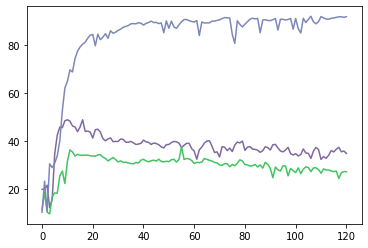

ROUND 120
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.650262


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027546
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043653

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.355707
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164708
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157434

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.929408
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019538
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055988

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.147789
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000185
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000136

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046916
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119146

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.808330
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002314
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002221

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.856172
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.553713
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008365

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.737028
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027196
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003496

Power Allocated= 4.389554359990696
CSI= 0.415029

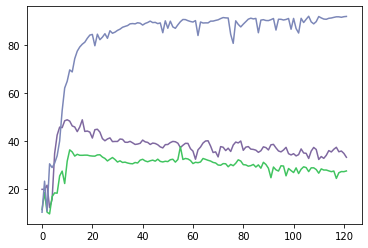

ROUND 121
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498823


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006764
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004427

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447625
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019926
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015543

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.309838
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039125
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000960

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.229643
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000127

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066524
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012806

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.908914
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095470
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000542

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.909088
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168361
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513555
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147712
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120291

Power Allocated= 4.389554359990696
CSI= 0.415029

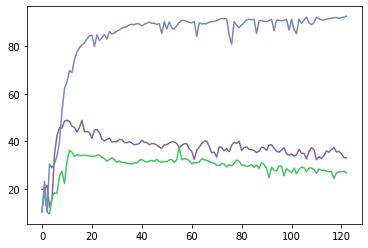

ROUND 122
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634460


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000273
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288485

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.718297
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003544
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063732

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.091961
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089809
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.676165

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206443
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000400
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000070

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037803
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.553459

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.746522
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054180
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002015

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.872031
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008931
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017938

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.239418
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031494
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026363

Power Allocated= 4.389554359990696
CSI= 0.415029

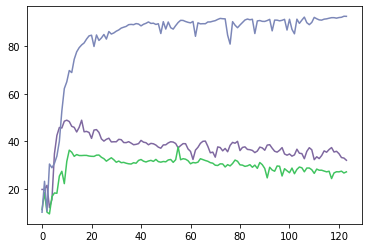

ROUND 123
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525551


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097881
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005082

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.418215
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021939
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044699

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.761934
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009408
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084085

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.172009
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000074
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142174
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.339325

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.739563
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020597
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041904

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.865279
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012820
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001532

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.790672
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026944
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027565

Power Allocated= 4.389554359990696
CSI= 0.415029

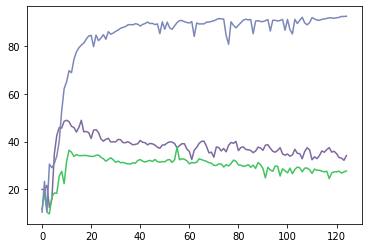

ROUND 124
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712050


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015694
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246654

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492616
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051960
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003478

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.942618
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003785
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024127

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.209407
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000007
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014883

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069738
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.332151

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.978748
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039888
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.149828

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.931564
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007840
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083177

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.616487
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025339
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006463

Power Allocated= 4.389554359990696
CSI= 0.415029

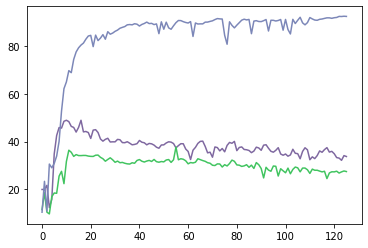

ROUND 125
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.584363


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024604
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153634

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.648378
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016220
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006312

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.944746
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009520
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015542

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.334845
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000026
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017673
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008614

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.627207
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069692
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000119

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.840975
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007016
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124032

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.644503
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127906
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078096

Power Allocated= 4.389554359990696
CSI= 0.415029

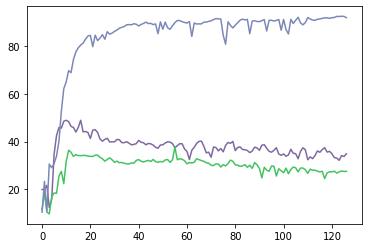

ROUND 126
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586484


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027303
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065859

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.638851
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001021
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.912452
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005940
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018176

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352014
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000032
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021867
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014560

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797619
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026529
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030787

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.839930
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004235
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048265

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.882223
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005124
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022106

Power Allocated= 4.389554359990696
CSI= 0.415029

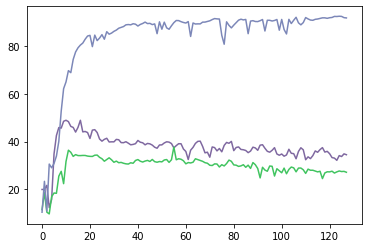

ROUND 127
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629194


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001013
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000068

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457470
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024004
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053652

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.825451
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013154
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023375

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.247299
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031752
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004668
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024021

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.937082
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.380264
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000014

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.999332
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027251
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069450

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725492
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010379
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010679

Power Allocated= 4.389554359990696
CSI= 0.415029

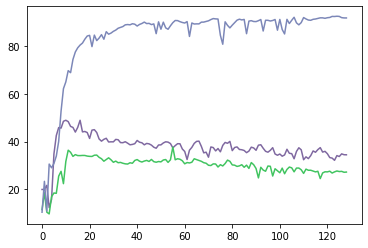

ROUND 128
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570990


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021062
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107706

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.738239
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014329
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.836589
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.352794
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014268

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259883
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000029
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001367

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039052
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404070

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.656815
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067317
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138185

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.950053
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008664
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024921

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.614244
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018478
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005239

Power Allocated= 4.389554359990696
CSI= 0.415029

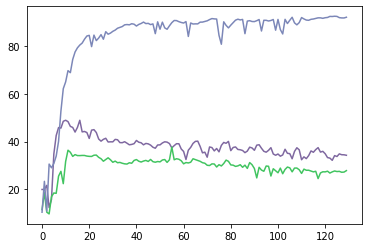

ROUND 129
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633231


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106867
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000819

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567638
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045164
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.820061

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.933386
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012551
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023777

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326112
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000456
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000909

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062193
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045129

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.599398
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045128
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123236

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.839258
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016413
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001763

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.666742
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059592
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004882

Power Allocated= 4.389554359990696
CSI= 0.415029

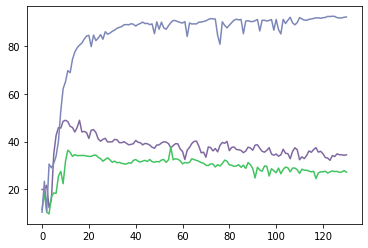

ROUND 130
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512685


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107180
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200638

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.656569
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039925
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009550

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.889314
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070553
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039105

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231389
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000793
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019909

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049128
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045723

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.805353
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043218
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080116

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827011
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000145
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000406

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.768831
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019677
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018283

Power Allocated= 4.389554359990696
CSI= 0.415029

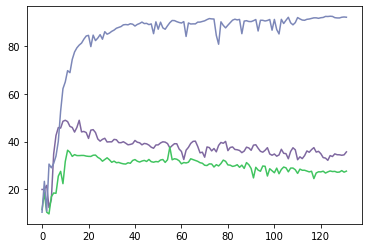

ROUND 131
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489114


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058095
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002105

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.624572
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019262
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219286

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.117010
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090108
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016015

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.210197
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000259
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003734
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049457

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.691388
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029153
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068101

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760710
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035908
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007369

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.688916
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011722
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070076

Power Allocated= 4.389554359990696
CSI= 0.415029

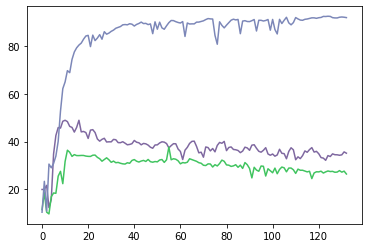

ROUND 132
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.711744


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142102
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001000

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448764
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001838
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019855

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.988487
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050723
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011108

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.221031
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071737
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008322

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725331
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063007
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.526525

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716886
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054664
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002611

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.754894
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008689
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037305

Power Allocated= 4.389554359990696
CSI= 0.415029

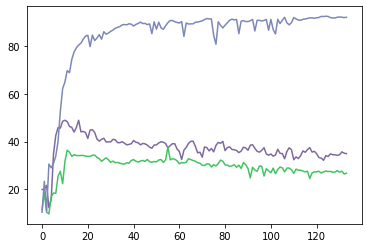

ROUND 133
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885029


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015872
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.290555

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468509
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002217
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002967

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.898858
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050150
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018160

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.187360
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000133
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012180
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032988

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.975467
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028787
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049217

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.029637
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040309
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002544

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.745165
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275354
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059189

Power Allocated= 4.389554359990696
CSI= 0.415029

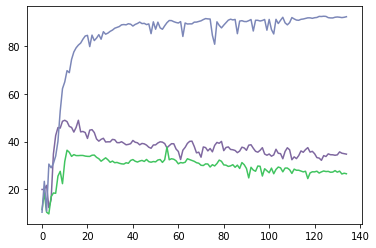

ROUND 134
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.521471


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004849
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068276

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621991
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007089
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005404

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.889803
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002311
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077665

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.211928
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000262
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015388
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.089163

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.846162
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022256
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095751

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.913757
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007869
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.342474

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.789456
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021268
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.368270

Power Allocated= 4.389554359990696
CSI= 0.415029

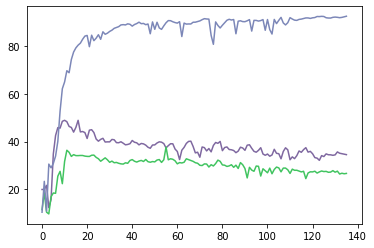

ROUND 135
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740240


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083223
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018228

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.658326
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012913
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065157

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.060898
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026294
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028842

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.161157
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000088
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063195
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027667

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.825510
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031694
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006055

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.927905
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044174
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.103998

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.670189
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019617
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.417090

Power Allocated= 4.389554359990696
CSI= 0.415029

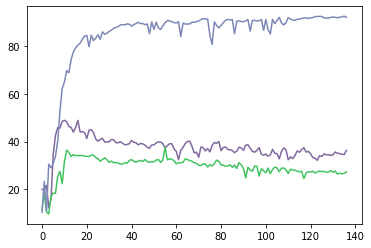

ROUND 136
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827739


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087321
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079332

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537197
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003813
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.990012
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025201
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206768

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.179796
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088006
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004256

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.858271
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015822
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002075

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.810499
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045794
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.291970

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940039
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068789
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357100

Power Allocated= 4.389554359990696
CSI= 0.415029

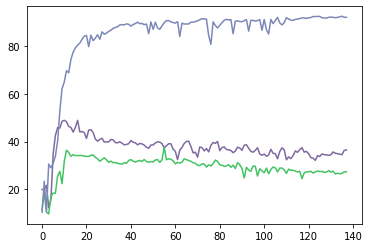

ROUND 137
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.616574


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006278
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239336

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489972
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016949
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011524

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.162460
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007394
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010226

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.282147
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000004
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034487
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005568

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.933895
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204893
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002562

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.820719
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074821
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000065

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721674
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011536
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010119

Power Allocated= 4.389554359990696
CSI= 0.415029

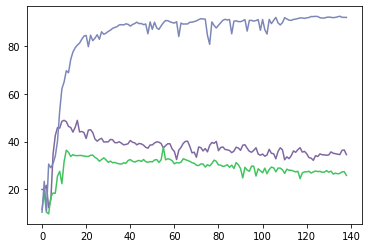

ROUND 138
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.832359


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034472
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001954

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451999
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015796
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081786

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.131928
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021286
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005449

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.147647
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011579
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002254

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090817
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093436

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932308
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057594
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008808

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.701431
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009079
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036217

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.029884
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330527
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026530

Power Allocated= 4.389554359990696
CSI= 0.415029

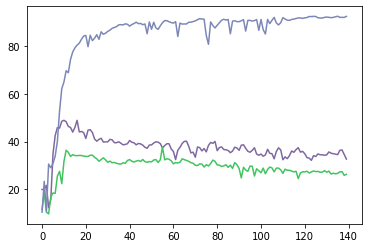

ROUND 139
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.722048


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061106
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004509

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303205
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019989
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000021

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.931314
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032792
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000350

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.214974
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010379
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029778
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066129

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.596007
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018717
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002316

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.701818
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017481
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071790

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.686660
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057559
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152629

Power Allocated= 4.389554359990696
CSI= 0.415029

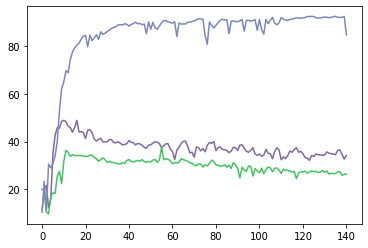

ROUND 140
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.700233


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017020
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156721

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.887647
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036698
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050604

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.949138
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035818
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053802

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.239247
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004208
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076455
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079325

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795466
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005052
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004625

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760800
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090112
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032428

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.117080
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009125
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001126

Power Allocated= 4.389554359990696
CSI= 0.415029

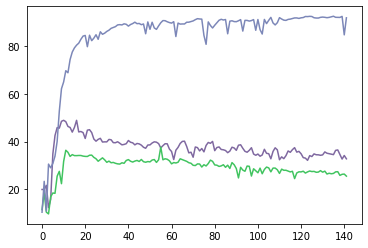

ROUND 141
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623928


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108043
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.363945

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.533389
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001514
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051564

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.724298
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014169
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015508

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.161892
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000005
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025778
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099621

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.900863
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003278
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000897

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.831501
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000566
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000657

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.795779
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023434
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033372

Power Allocated= 4.389554359990696
CSI= 0.415029

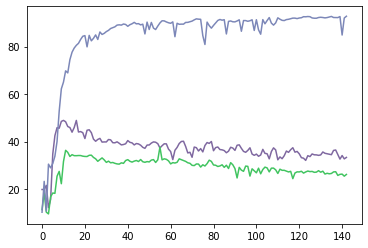

ROUND 142
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.677646


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063923
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144484

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436443
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062636
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005483

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.979072
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179002
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007535

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.199931
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059754
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000447

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609185
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010545
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000264

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.842476
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186905
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013635

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.707642
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023723
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086296

Power Allocated= 4.389554359990696
CSI= 0.415029

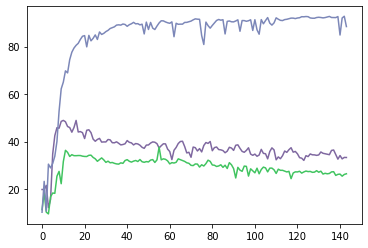

ROUND 143
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.904875


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139439
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.436365

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563809
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001817
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000164

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947396
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024404
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008997

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.235320
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000018
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001536

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137681
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232006

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.908214
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069267
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000026

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.799722
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013161
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003247

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.938351
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024436
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004592

Power Allocated= 4.389554359990696
CSI= 0.415029

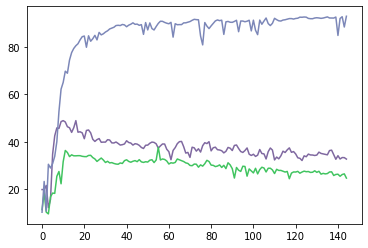

ROUND 144
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.728700


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058584
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.277556

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504188
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001803
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005445

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633475
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004801
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000079

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.142498
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000005
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046094
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.527024

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.833831
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008082
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001965

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940002
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006060
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003078

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.791078
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132827
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050183

Power Allocated= 4.389554359990696
CSI= 0.415029

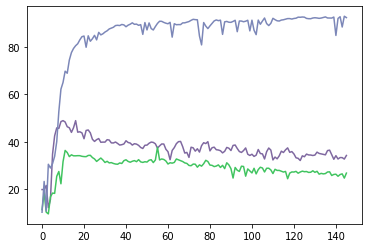

ROUND 145
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.666161


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019796
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009872

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605315
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000068
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029566

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.784941
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000004
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.600576

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.182909
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007942
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006675

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168454
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022492

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.807357
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055456
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056534

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721593
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000085
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000335

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.828792
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043487
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016608

Power Allocated= 4.389554359990696
CSI= 0.415029

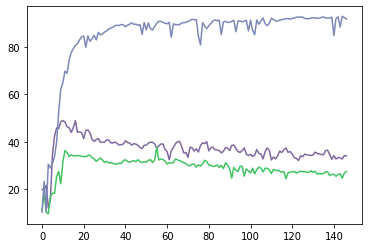

ROUND 146
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.888583


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026956
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276664

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.571643
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076162
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066420

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.994694
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029774
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041186

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.241923
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000886
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.709878
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.160932

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.968252
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001990
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079049

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.895541
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006289
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007062

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.213890
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163600
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092752

Power Allocated= 4.389554359990696
CSI= 0.415029

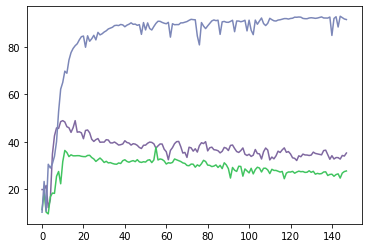

ROUND 147
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.705879


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021159
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015236

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.654148
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000588
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023116

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.224791
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025081
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.228401
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005981
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131875
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062865

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.778050
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107643
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001949

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.841673
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033399
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255728

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.674160
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003056
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012747

Power Allocated= 4.389554359990696
CSI= 0.415029

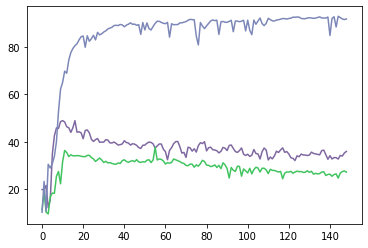

ROUND 148
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.955699


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001797
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043086

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662865
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005448
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.030947
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053215
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095513

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.133147
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000006
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165393
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150984

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.771320
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053739
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055489

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.886417
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004355
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027517

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.982018
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072288
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028717

Power Allocated= 4.389554359990696
CSI= 0.415029

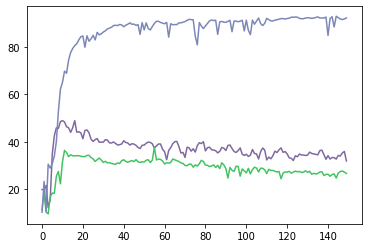

ROUND 149
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827779


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117550
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045704

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389630
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027608
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005227

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.107510
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065398
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073133

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.236962
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205243

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036658
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.191389

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.839624
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015739
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010330

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.823450
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017103
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000653

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569375
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094196
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005393

Power Allocated= 4.389554359990696
CSI= 0.415029

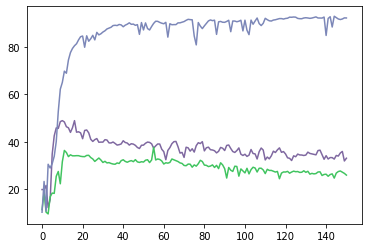

ROUND 150
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613883


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092982
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024927

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548082
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055920
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.099375
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121218
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018134

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.192834
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000007
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013948
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.608765

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.579692
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124248
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.652749
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000478
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000638

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.827206
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013822
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020035

Power Allocated= 4.389554359990696
CSI= 0.415029

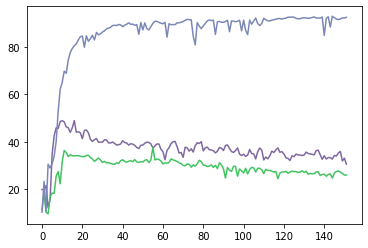

ROUND 151
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.553926


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065916
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.369367

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531768
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179202
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009328

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.174491
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.425692
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014519

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.265756
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000499
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139454
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.470576

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.657767
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005813
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.785963
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005599
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036134

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.965174
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070247
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205396

Power Allocated= 4.389554359990696
CSI= 0.415029

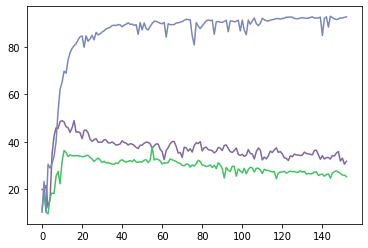

ROUND 152
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.765308


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053074
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032932

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403497
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014493
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111494

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.894221
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085174
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.382995

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.247748
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024377
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030913

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.772891
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005628
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009704

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.826947
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000002
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000018

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.807931
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059956
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176488

Power Allocated= 4.389554359990696
CSI= 0.415029

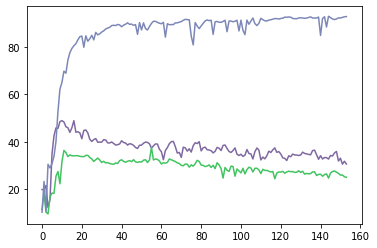

ROUND 153
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.702285


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050184
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019059

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605063
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017869
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128132

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.813316
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001224
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014305

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259631
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000838
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083325
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024389

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.837395
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156190
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179895

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.619660
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000669
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.304241

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.875034
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001114
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036068

Power Allocated= 4.389554359990696
CSI= 0.415029

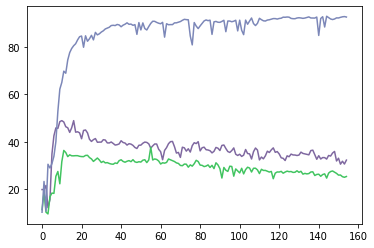

ROUND 154
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.585985


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000939
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044242

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.588307
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054946
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000724

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.877296
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065829
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.165070

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.208583
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000277
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047488
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041983

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.894080
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034317
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002808

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.958504
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013679
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000027

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.693271
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010024
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075644

Power Allocated= 4.389554359990696
CSI= 0.415029

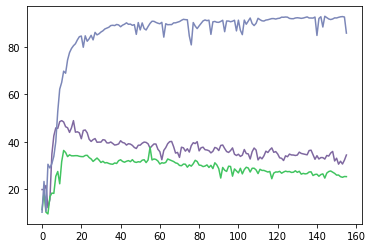

ROUND 155
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.963279


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009213
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066963

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676117
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003527
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.343966

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.925373
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014014
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025150

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.204367
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103727
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074412
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054049

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.228147
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024480
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038461

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.870119
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007524
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174413

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.963964
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000576
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000259

Power Allocated= 4.389554359990696
CSI= 0.415029

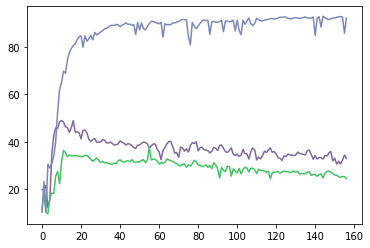

ROUND 156
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.698330


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042032
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169454

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326354
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033578
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006380

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.911232
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060189
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216560

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.123551
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040063
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011006

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054856
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011519

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008045
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070359
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006265

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.692227
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012152
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047281

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.831159
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014221
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108761

Power Allocated= 4.389554359990696
CSI= 0.415029

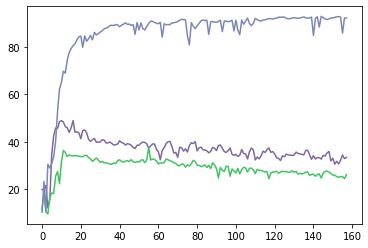

ROUND 157
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.938863


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167029
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030166

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.553047
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023599
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003849

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.146078
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093433
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.137103

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.189826
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000120
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023676
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051269

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.775748
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000630
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007221

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.863706
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003203
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002090

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530168
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033980
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006240

Power Allocated= 4.389554359990696
CSI= 0.415029

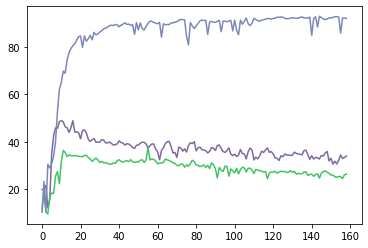

ROUND 158
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.671298


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189985
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000882

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503276
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000121
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058391

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.052006
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011945
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.128314

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.175285
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228003
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036764

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.878336
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009164
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057049

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.121448
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032076
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.727887

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.744989
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002526
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201300

Power Allocated= 4.389554359990696
CSI= 0.415029

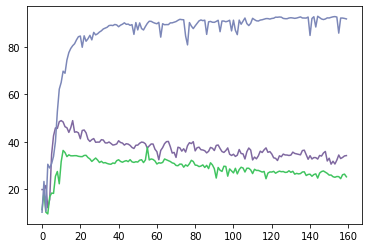

ROUND 159
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.062801


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039633
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000062

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.549614
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002793
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001358

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.361740
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021678
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081181

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.228339
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156311
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220211

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.904224
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024339
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.083883

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.984927
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101617
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.312768

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.600959
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054798
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013125

Power Allocated= 4.389554359990696
CSI= 0.415029

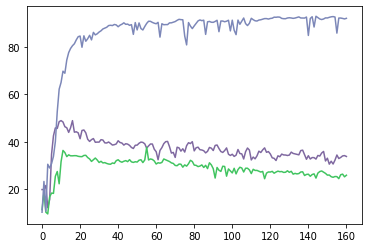

ROUND 160
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682943


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003195
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020101

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.464504
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004974
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004828

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.039693
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014901
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072160

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.196834
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030700
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017065

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.103151
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018609
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042147

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.867610
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158295
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566247

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542909
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006849
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000074

Power Allocated= 4.389554359990696
CSI= 0.415029

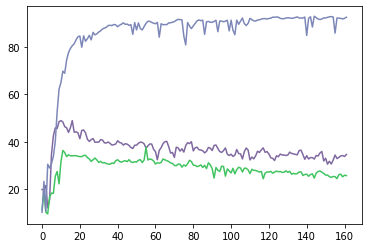

ROUND 161
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587733


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032400
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001140

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407940
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.884500
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178557
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028086

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.309102
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000009
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156596

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057885
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100162

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.729094
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003923
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002340

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874147
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072147
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.544840

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.908994
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000156
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141667

Power Allocated= 4.389554359990696
CSI= 0.415029

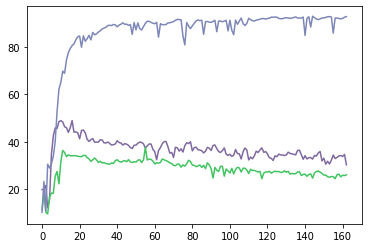

ROUND 162
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632201


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055240
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003121

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449627
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003060
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000038

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.850855
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062055
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014356

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.241706
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002035
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032928
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019719

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004643
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038261
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199366

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.109294
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188130
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.496641

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.647658
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076413
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001702

Power Allocated= 4.389554359990696
CSI= 0.415029

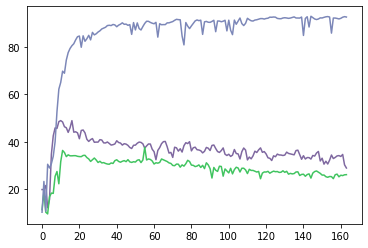

ROUND 163
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.614630


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016211
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.186264

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474302
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165615
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.997675
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066274
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.472514

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259807
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124158
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040705

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.745345
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002026
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002136

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.847071
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015766
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247536

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.518714
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001349
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055304

Power Allocated= 4.389554359990696
CSI= 0.415029

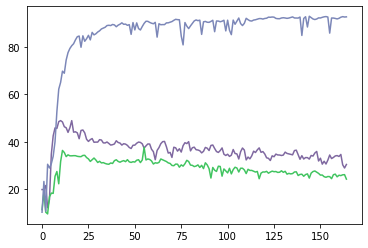

ROUND 164
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.604949


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003018
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019897

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359373
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000339
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004943

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.071365
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119943
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005650

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.163449
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000002
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084575
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006535

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.576132
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001008
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.037901

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.696682
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062062
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075201

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848829
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010552
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.388387

Power Allocated= 4.389554359990696
CSI= 0.415029

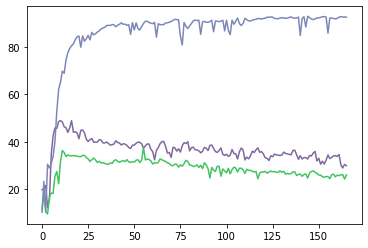

ROUND 165
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526459


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005731
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022863

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595280
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007371
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000984

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.856410
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006620
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014407

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.138330
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054277
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074648

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.864826
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109159
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.939543
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031551
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.274968

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721859
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013119
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107600

Power Allocated= 4.389554359990696
CSI= 0.415029

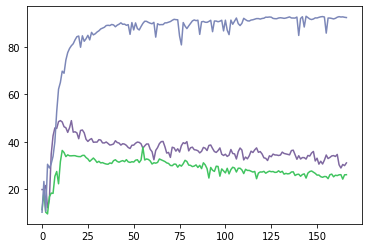

ROUND 166
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629994


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003526
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003651

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379986
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018805
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019366

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947454
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027564
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.018541

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.128619
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053554
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095265

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613328
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109223
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046427

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.697993
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035899
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.435526

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664036
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041323
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016366

Power Allocated= 4.389554359990696
CSI= 0.415029

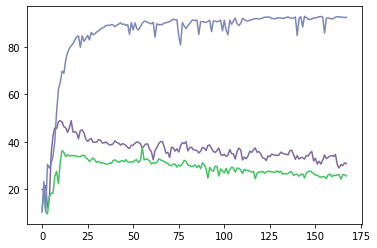

ROUND 167
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.647142


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043140
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005683

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.774194
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003134
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004842

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.774623
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007855
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000073

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.148716
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000015
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060602
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.400490

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497124
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002945
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.159523

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.912377
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049116
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176731

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.719533
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013943
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 4.389554359990696
CSI= 0.415029

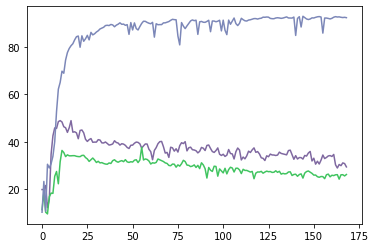

ROUND 168
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.529934


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006354
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.594436

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.425130
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003950
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004498

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.038778
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064178
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049896

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389600
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000666
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005669
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054729

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613897
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061915
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231170

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.790657
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019253
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.185769

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621582
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015853
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076811

Power Allocated= 4.389554359990696
CSI= 0.415029

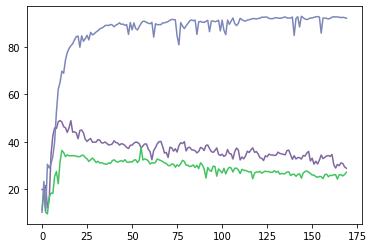

ROUND 169
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.681389


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005326
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084663

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590916
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179409
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029194

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.929254
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029743
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046314

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.282588
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005356
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076653
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125372

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.778070
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051316
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.571074

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.005704
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075492
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064770

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.793132
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088305
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.556080

Power Allocated= 4.389554359990696
CSI= 0.415029

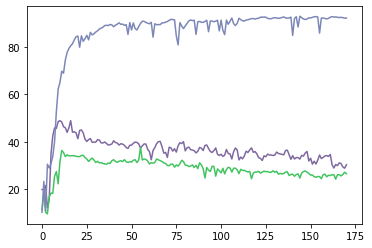

ROUND 170
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.540924


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113738
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064559

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.822777
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011046
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000033

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.757707
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047553
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025132

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.153156
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000082

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062602
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224397

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.931317
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004681
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079635

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.984610
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303982
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.280480

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663270
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014301
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002434

Power Allocated= 4.389554359990696
CSI= 0.415029

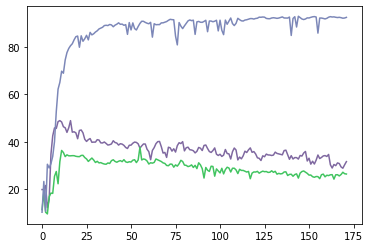

ROUND 171
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615590


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000998
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002009

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593709
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041621
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.094958
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048918
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032068

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.251567
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000003
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036370
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035926

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897370
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006583
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121260

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798962
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025590
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.101065

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.801082
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006962
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000022

Power Allocated= 4.389554359990696
CSI= 0.415029

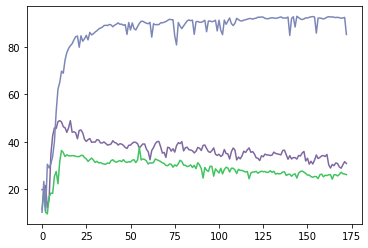

ROUND 172
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.090761


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046000
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.380365

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.396658
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142432
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682081
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066116
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256897
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154701
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.202705
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060158

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.012604
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139586
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060994

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.208080
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054526
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099362

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Poor Channel, client not taken for averaging in this round

Power Allocated= 4.389554359990696
CSI= 0.4150296202023779
SNR= 32.3532300867759
Client: client33
Model client33 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259808
Model cli

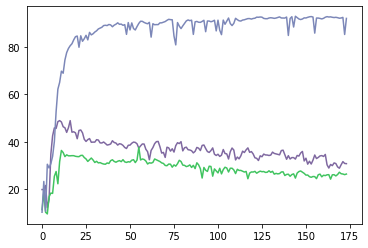

ROUND 173
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.738019


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056697
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004208

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.464994
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000001
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201757

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.743700
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049325
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000592

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.215349
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019890
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070747

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.785408
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003244
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169309

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712459
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019348
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.162578

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.794755
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018750
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147216

Power Allocated= 4.389554359990696
CSI= 0.415029

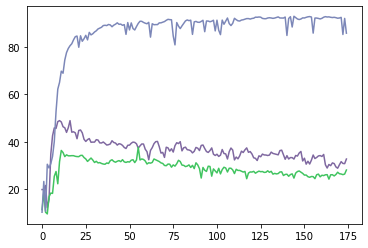

ROUND 174
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.204501


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025822
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051871

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435567
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000056
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.746422
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035433
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.385869

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.277136
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090782
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.233064

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.067915
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114575
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000514

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.782464
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024925
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060447

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664734
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129445
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121587

Power Allocated= 4.389554359990696
CSI= 0.415029

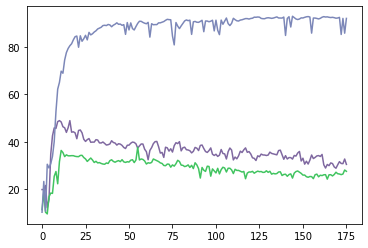

ROUND 175
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.700595


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064474
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.555015

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350532
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.647171
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145322

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.748511
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064469
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.930786

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335427
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057597
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242486
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014415

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.579716
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059126
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189910

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.879109
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065108
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134443

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.729325
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004768
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.121779

Power Allocated= 4.389554359990696
CSI= 0.415029

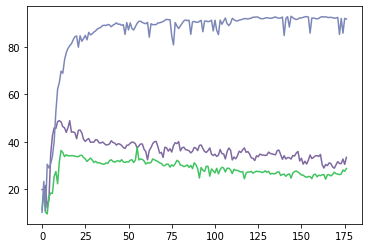

ROUND 176
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593201


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003110
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094419

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350935
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005734
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061532

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720795
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118165
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017773

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.226565
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000000
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119972
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003784

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.829297
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012511
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002239

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797885
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072783
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064999

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.558400
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024750
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117591

Power Allocated= 4.389554359990696
CSI= 0.415029

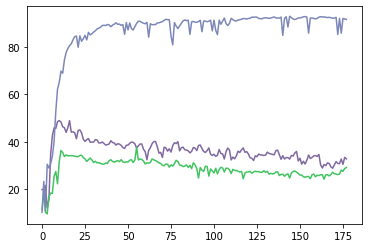

ROUND 177
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682893


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022021
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095268

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513161
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001411
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000200

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.123758
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071348
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061178

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411761
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000031
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009737
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040160

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.994673
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108736
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.700723

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.805647
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006521
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006996

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.700587
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003587
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 4.389554359990696
CSI= 0.415029

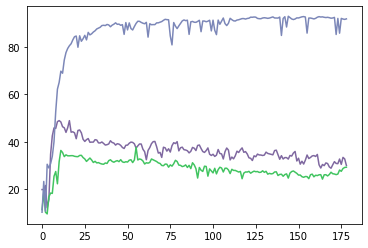

ROUND 178
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620348


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021060
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000150

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.506739
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023034
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000013

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.437596
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019403
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058052

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316805
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084415
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000003

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013547
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040062

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017953
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094349
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033925

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.753476
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069365
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008446

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663047
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096241
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144170

Power Allocated= 4.389554359990696
CSI= 0.415029

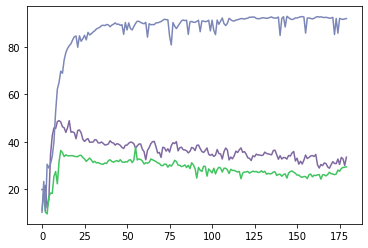

ROUND 179
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.657387


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023930
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000009

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.652882
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200357
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008966

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.949898
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017098
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052510

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.217517
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205526
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055829
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043740

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623879
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028919
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043867

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.852466
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006860
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135417

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664028
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013725
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035799

Power Allocated= 4.389554359990696
CSI= 0.415029

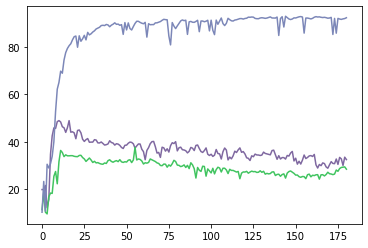

ROUND 180
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.629911


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048035
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007725

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664751
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030560
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000019

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.916946
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037799
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190602

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.230437
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000069
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.558143

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026389
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004264

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.815739
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045551
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132812

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.884148
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058787
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071783

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.783348
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028706
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133878

Power Allocated= 4.389554359990696
CSI= 0.415029

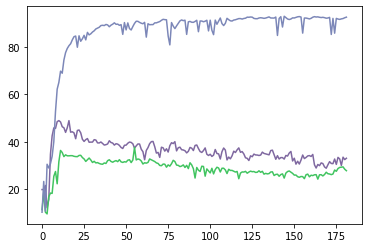

ROUND 181
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.681340


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014388
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.359068

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703946
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006390
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035099

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.802703
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144031
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030132

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.336713
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077162
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.906395

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051522
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105796

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.756389
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035299
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060191

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.815836
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072290
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000063

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.865128
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025336
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031716

Power Allocated= 4.389554359990696
CSI= 0.415029

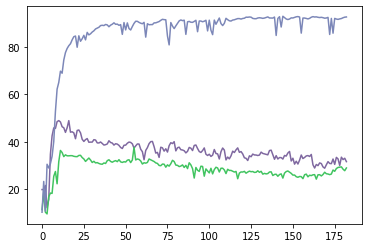

ROUND 182
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.635131


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031824
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379044
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.026241
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030174

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.228224
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025389
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.036977

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.236557
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183338
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000907

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007526
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035229

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.921343
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122958
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017499

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649968
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013299
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067804

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640903
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146391
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122401

Power Allocated= 4.389554359990696
CSI= 0.415029

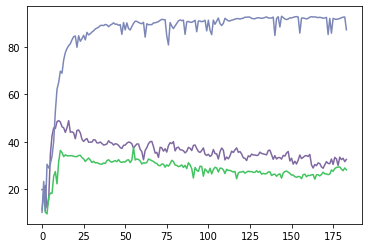

ROUND 183
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.996902


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151405
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005552

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375710
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002978
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006311

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.512121
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052245
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020891

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.312428
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.271624
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008393

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048925
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.039411

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.745924
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015086
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027032

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.759106
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022027
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120993

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008552
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044183
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357492

Power Allocated= 4.389554359990696
CSI= 0.415029

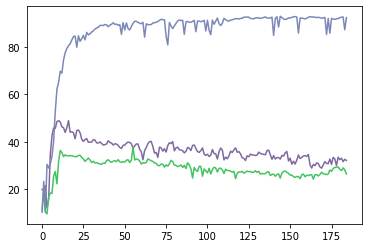

ROUND 184
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.752087


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179273
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.298250

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.508709
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002886
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.888808
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075420
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000714

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.188954
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010589
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000087

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017698
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.668996

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.781932
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094374
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.151192

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.742920
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152402
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114814

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720064
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007639
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040215

Power Allocated= 4.389554359990696
CSI= 0.415029

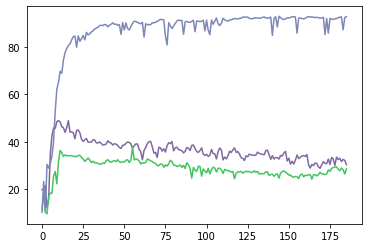

ROUND 185
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649661


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115680
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043903

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494934
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017125
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006597

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020421
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002794
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043738

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.263151
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000690
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001974

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112686
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055270

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725659
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109816
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059255

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.810828
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.316616
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086925

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667665
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018308
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031216

Power Allocated= 4.389554359990696
CSI= 0.415029

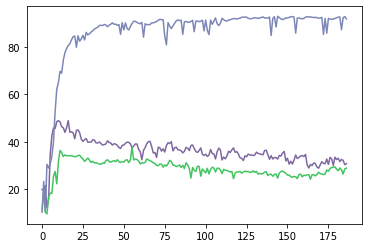

ROUND 186
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466171


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007881
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005306

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.574042
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000306
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000570

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740592
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017153
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019756

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261243
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007893
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027127

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031710
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042348

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.919774
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007009
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051698

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634645
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130977
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.428298

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.198879
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100356
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.014684

Power Allocated= 4.389554359990696
CSI= 0.415029

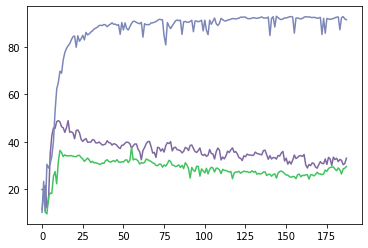

ROUND 187
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.835734


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010750
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002651

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481205
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010577
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035588

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.874002
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104383
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.352896

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.238021
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047501
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000029

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215420
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062932

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017125
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002278
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004081

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716558
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075378
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058875

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.819651
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022698
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025624

Power Allocated= 4.389554359990696
CSI= 0.415029

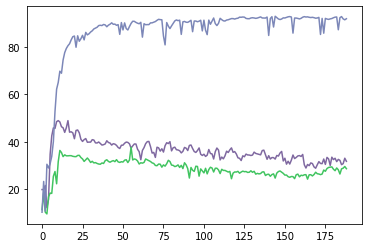

ROUND 188
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.746056


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011559
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090353

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609487
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017510
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006000

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.898623
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007823
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040252

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.210962
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001831
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000001

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032254
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073807

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.732185
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047179
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.008752

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.819504
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096886
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123376

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.804480
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020566
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008615

Power Allocated= 4.389554359990696
CSI= 0.415029

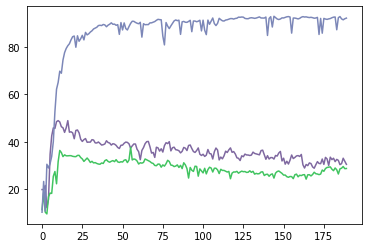

ROUND 189
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.830729


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189113
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.127099

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535405
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075456
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004363

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.063240
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039150
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060965

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.136861
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022156
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004430

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079648
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008517

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620901
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050293
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.689891
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006193
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007225

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.718221
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.003362
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004413

Power Allocated= 4.389554359990696
CSI= 0.415029

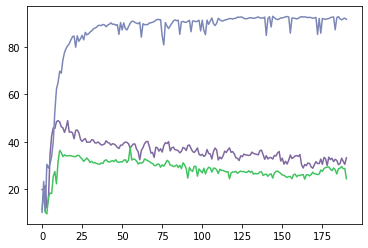

ROUND 190
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.582547


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096031
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161588

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.801039
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059932
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282812

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.955912
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013127
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009473

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.280145
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009095
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000040

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085729
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064128

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.665923
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045722
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025810

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.191151
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045618
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.764626

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.898174
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001171
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002815

Power Allocated= 4.389554359990696
CSI= 0.415029

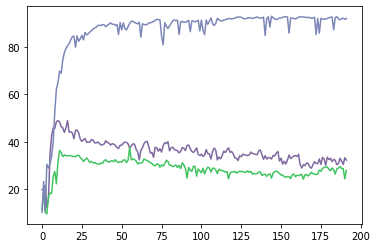

ROUND 191
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.736639


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058968
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152009

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.817631
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016982
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197614

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.957999
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048310
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.119740
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024631
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.267912

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036990
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004810

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640286
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060507
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045513

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.771886
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.006475
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002840

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.731344
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009554
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.007398

Power Allocated= 4.389554359990696
CSI= 0.415029

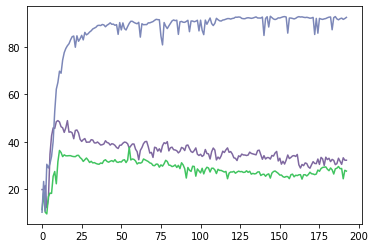

ROUND 192
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.835277


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159057
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.280274

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663276
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004709
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035143

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.070932
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039365
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022777

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.232283
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000005
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000220

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011480
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.646890

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663698
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281079
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013342

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.691463
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022338
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000399

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.865624
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021199
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001165

Power Allocated= 4.389554359990696
CSI= 0.415029

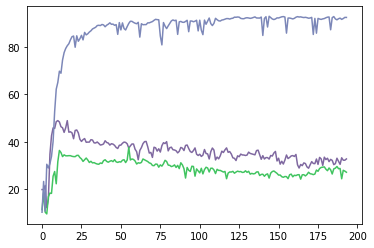

ROUND 193
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640461


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021795
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.024463

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.660350
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000640
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.040852

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.994799
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013681
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009299

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.213211
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000045
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000044

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138590
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023940

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.748567
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018596
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003426

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.866259
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231598
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422833

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.857821
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062207
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135560

Power Allocated= 4.389554359990696
CSI= 0.415029

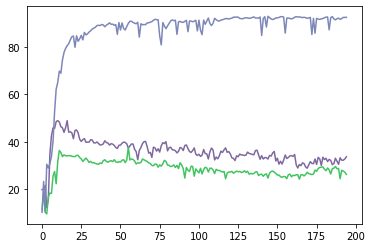

ROUND 194
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.631689


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062082
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.991822

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532001
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015877
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015122

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.021874
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045337
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.168727

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.297545
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000009
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081068

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347880
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054948

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763376
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081141
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001745

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.684886
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125629
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117851

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798574
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021901
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022030

Power Allocated= 4.389554359990696
CSI= 0.415029

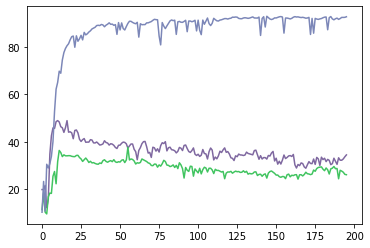

ROUND 195
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.677380


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.016777
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093180

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.793280
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000134
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001437

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.042681
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032626
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079689

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326947
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000030
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000000

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.492932
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.195638

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.889170
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.308124
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048440

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.932944
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013523
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.835931

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.652313
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086130
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379013

Power Allocated= 4.389554359990696
CSI= 0.415029

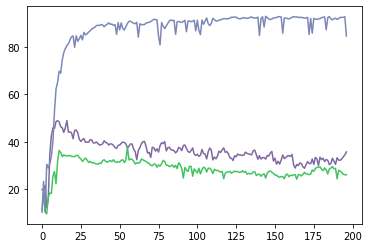

ROUND 196
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.043046


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.001181
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.001558

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.751009
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002360
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000447

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.807256
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039426
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000230

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.264545
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000108
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000425

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038812
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077215

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.108467
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008312
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.025888

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.886924
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065592
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.361763

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.737112
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049700
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150235

Power Allocated= 4.389554359990696
CSI= 0.415029

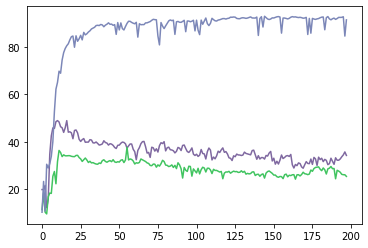

ROUND 197
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.959922


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066065
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094508

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.575663
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000003
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.072826

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.048961
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023737
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063561

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.227084
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000314
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008879

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079689
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062608

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.834300
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.008364
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250306

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.803081
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030907
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003852

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.810637
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098838
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.016907

Power Allocated= 4.389554359990696
CSI= 0.415029

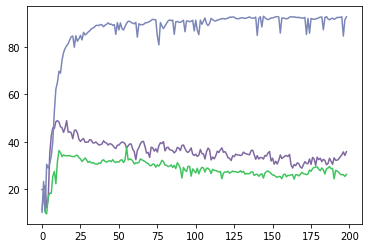

ROUND 198
0.14708000000000937
Power Allocated= 5.24053640816837
CSI= 0.6416489730528875
SNR= 29.020919520436344
Client: client1
Model client1 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667664


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client1 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076969
Model client1 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056252

Power Allocated= 4.480929838507763
CSI= 0.43138943026516496
SNR= 23.573223567944222
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593268
Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000068
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.011544

Power Allocated= 3.6262236962029424
CSI= 0.3151792953819794
SNR= 25.447024978853666
Client: client7
Model client7 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.770736
Model client7 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018571
Model client7 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.012872

Power Allocated= 5.122066491795499
CSI= 0.5963191191531012
SNR= 30.448595208027594
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360341
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.000885
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000123

Power Allocated= 5.465575674524906
CSI= 0.7499370429019612


/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083748
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113306

Power Allocated= 4.713003454977209
CSI= 0.4793823669782571
SNR= 32.445993417459846
Client: client25
Model client25 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663590
Model client25 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.010779
Model client25 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.450291

Power Allocated= 4.972783324804684
CSI= 0.5475738705306437
SNR= 29.858731927544184
Client: client29
Model client29 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.769627
Model client29 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029602
Model client29 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076075

Power Allocated= 5.228352518480461
CSI= 0.6366716142456257
SNR= 22.77820497297263
Client: client32
Model client32 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.636702
Model client32 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015352
Model client32 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.376183

Power Allocated= 4.389554359990696
CSI= 0.415029

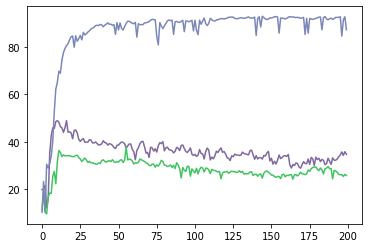

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]   
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[19.85, 11.39, 10.29], [19.86, 18.48, 23.27], [21.58, 10.32, 10.75], [12.21, 9.58, 30.52], [15.65, 16.79, 28.95], [34.76, 18.37, 30.78], [42.52, 18.24, 33.87], [45.86, 25.46, 40.07], [45.64, 27.47, 52.78], [48.5, 22.29, 62.2], [48.93, 31.6, 65.04], [48.36, 36.35, 69.78], [46.36, 35.47, 68.92], [45.91, 33.75, 74.49], [43.97, 34.5, 77.62], [45.92, 34.09, 79.36], [48.92, 34.08, 80.52], [44.05, 34.15, 81.35], [44.22, 34.14, 82.99], [43.77, 33.88, 84.32], [41.29, 33.76, 84.6], [44.78, 33.73, 79.87], [44.98, 34.24, 84.7], [43.77, 34.3, 82.4], [41.06, 33.35, 83.46], [40.15, 32.77, 84.9], [40.91, 31.72, 82.98], [41.36, 32.46, 86.14], [39.8, 33.15, 85.09], [39.87, 32.32, 85.55], [39.86, 31.27, 86.29], [40.89, 31.77, 86.81], [40.74, 31.09, 87.59], [39.54, 31.22, 87.96], [39.5, 30.86, 88.3], [39.91, 30.62, 89.02], [39.3, 30.53, 89.14], [38.62, 31.07, 89.02], [38.78, 30.86, 89.48], [39.09, 32.04, 89.29], [40.44, 32.42, 88.52], [39.7, 31.72, 89.19], [39.47, 31.38, 89.59], [38.61, 31.79, 90.17], [3